In [1]:
library(tidyverse)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.1     
✔ ggplot2   3.4.4          ✔ tibble    3.2.1     
✔ lubridate 1.9.2          ✔ tidyr     1.3.0     
✔ purrr     1.0.2          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Sb.c4_markers.bed",
                "/home/jpm73279/genome_downloads/C4_markers/Zm.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}e

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species)

Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
###### Define a function to read the data and add columns
read_and_annotate_intersect <- function(file_path, species_abbr) {
  read_delim(file_path, delim = "\t", col_names = FALSE, col_types = "cccccccccc") %>%
    dplyr::mutate(
      species = species_abbr
    )
}

files_conditions <- list(
list(path = "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/all_acr_intersections/sb.extended_c4_genes.acr_intersection.all.bed", species = "Sb"),
list(path = "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/all_acr_intersections/zm.extended_c4_genes.acr_intersection.all.bed", species = "Zm")
)

# Read and annotate each file and store results in a list
annotated_data_list <- lapply(files_conditions, function(condition) {
  read_and_annotate_intersect(condition$path, condition$species)
})

# Combine results
combined_acrs_species <- bind_rows(annotated_data_list)

all_acrs_species_types <- combined_acrs_species %>% 
    ungroup() %>% 
    dplyr::left_join(., markers, by = c("species", "X5" = "name")) %>% 
    dplyr::rename(name = X5) %>% 
    rename(enzyme_location = type,
          locus = name,
          acr_name_type = X9) %>% 
    separate(acr_name_type, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)


##Only caring about DITs in this lifetime
filterd_DITs <- all_acrs_species_types %>% 
    dplyr::filter(gene_family == "DIT")


#Split for filtering 
filterd_DITs_sb <- filterd_DITs  %>% 
    dplyr::filter(species == "Sb")

filterd_DITs_zm <- filterd_DITs  %>% 
    dplyr::filter(species == "Zm")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [10, 11, 12, 13,
14].”


In [4]:

## Generate for sampling and re-sampling 
dit_number_species <- filterd_DITs %>% 
    dplyr::select(locus, acr, species) %>% 
    dplyr::distinct() %>% 
    dplyr::group_by(locus, species) %>% 
    summarise(acr_count = n())
dit_number_species

`summarise()` has grouped output by 'locus'. You can override using the
`.groups` argument.


locus,species,acr_count
<chr>,<chr>,<int>
Sb__DIT_1,Sb,8
Sb__DIT_2,Sb,4
Sb__DIT_3,Sb,3
Sb__DIT_4,Sb,2
Zm__DIT_1,Zm,5
Zm__DIT_2,Zm,5


In [5]:
process_fimo_hits <- function(fimo_output, acr_file) {
  
  # Read the FIMO output
  zm_fimo_output <- read_tsv(fimo_output, col_types = "cccddcdddc")
  
  zm_fimo_filtered_output <- zm_fimo_output %>% 
    separate(sequence_name, c("acrID", "region"), sep = "::") %>% 
    separate(acrID, c("acr", "type"), sep = ";", remove = FALSE) %>% 
    dplyr::filter(acr %in% acr_file$acr)
  
    rm(zm_fimo_output)
    gc()
  return(zm_fimo_filtered_output)
}



read_fimo_for_null <- function(fimo_output, species_name) {

  # Read the FIMO output
  zm_fimo_output <- read_tsv(fimo_output)
  
  zm_fimo_filtered_output <- zm_fimo_output %>% 
    separate(sequence_name, c("acrID", "region"), sep = "::") %>% 
    separate(acrID, c("acr", "type"), sep = ";", remove = FALSE) %>% 
        dplyr::mutate(species = species_name)
    
  return(zm_fimo_filtered_output)
}



In [6]:
zm_fimo_counts_null_all <- read_fimo_for_null("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/all_acrs/zm_fimo_output/fimo.tsv", "Zm")
zm_fimo_counts_null_de_novo <- read_fimo_for_null("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/all_acrs/zm_fimo_output_de_novo/fimo.tsv", "Zm")
sb_fimo_counts_null_all <- read_fimo_for_null("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/all_acrs/sb_fimo_output/fimo.tsv", "Sb")
sb_fimo_counts_null_denovo <- read_fimo_for_null("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/all_acrs/sb_fimo_output_de_novo/fimo.tsv", "Sb")

fimo_binding_regions_all <- bind_rows(zm_fimo_counts_null_all, zm_fimo_counts_null_de_novo,
         sb_fimo_counts_null_all,sb_fimo_counts_null_denovo)

rm(sb_fimo_counts_null_denovo)
rm(sb_fimo_counts_null_all)
rm(zm_fimo_counts_null_de_novo)
rm(zm_fimo_counts_null_all)
gc()


Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 149440 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): motif_id, sequence_name, strand, matched_sequence
dbl (5): start, stop, score, p-value, q-value
lgl (1): motif_alt_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 202048 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): motif_id, motif_alt_id, sequence_name, strand, matched_sequence
dbl (5): start, stop, score, p-value, q-value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Sp

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1352553,72.3,4116540,219.9,4116540,219.9
Vcells,12785518,97.6,25954938,198.1,22719692,173.4


In [7]:

## Old verisons, though nothing has changed.
# zm_fimo_counts_all <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/all_acrs/zm_fimo_output/fimo.tsv",filterd_DITs_zm)
# zm_fimo_counts_denovo <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/all_acrs/zm_fimo_output_de_novo/fimo.tsv", filterd_DITs_zm)
# sb_fimo_counts_all <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/all_acrs/sb_fimo_output/fimo.tsv", filterd_DITs_sb)
# sb_fimo_counts_denovo <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/all_acrs/sb_fimo_output_de_novo/fimo.tsv", filterd_DITs_sb)


In [8]:
# ## UPDATED MOTIF CALLING BASED OFF OF RE-DOING FIMO WITH LESS ACRSSSS
# zm_fimo_counts_all <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/motif_analysis/zm_fimo_output_all_tfs/fimo.tsv",filterd_DITs_zm)
# zm_fimo_counts_denovo <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/motif_analysis/zm_fimo_output_de_novo/fimo.tsv", filterd_DITs_zm)
# sb_fimo_counts_all <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/motif_analysis/sb_fimo_output_all_tfs/fimo.tsv", filterd_DITs_sb)
# sb_fimo_counts_denovo <- process_fimo_hits("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/motif_analysis/sb_fimo_output_de_novo/fimo.tsv", filterd_DITs_sb)


In [9]:
# all_combined_fimo_hits <- bind_rows(zm_fimo_counts_all, zm_fimo_counts_denovo,
#          sb_fimo_counts_all, sb_fimo_counts_denovo)

all_combined_fimo_hits_filtered <- fimo_binding_regions_all %>% 
    dplyr::filter(acr %in% filterd_DITs$acr)


combined_fimo_hits_info <- left_join(all_combined_fimo_hits_filtered, filterd_DITs, by = c("acr", "species")) %>% 
    dplyr::filter(is.na(gene_family) != TRUE)

Warning message in left_join(all_combined_fimo_hits_filtered, filterd_DITs, by = c("acr", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 162 of `x` matches multiple rows in `y`.
ℹ Row 21 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [10]:
combined_fimo_hits_info <- combined_fimo_hits_info 


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


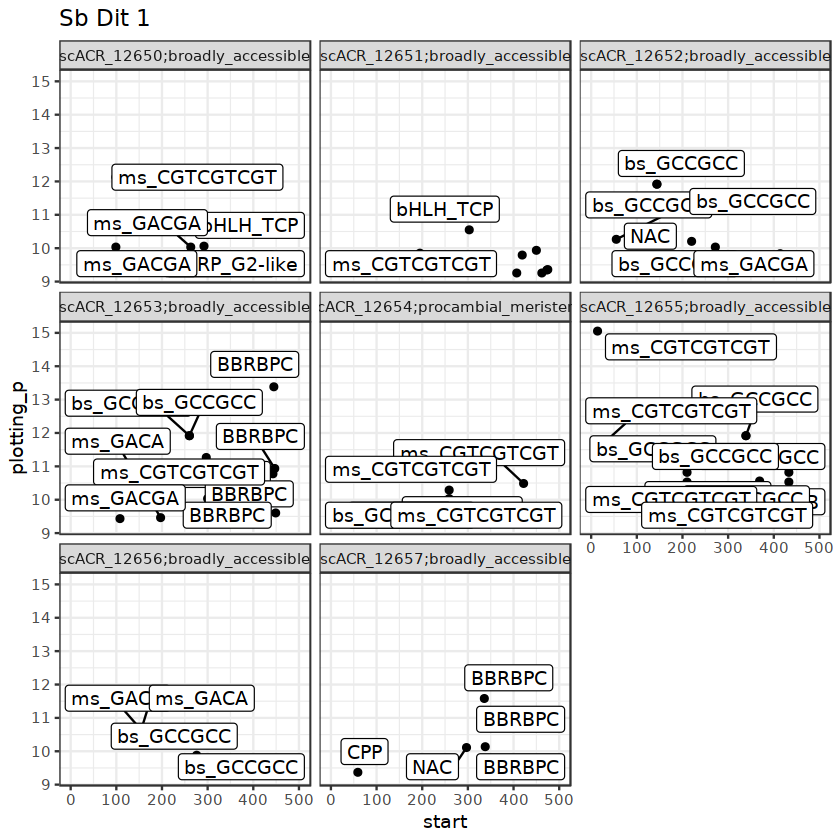

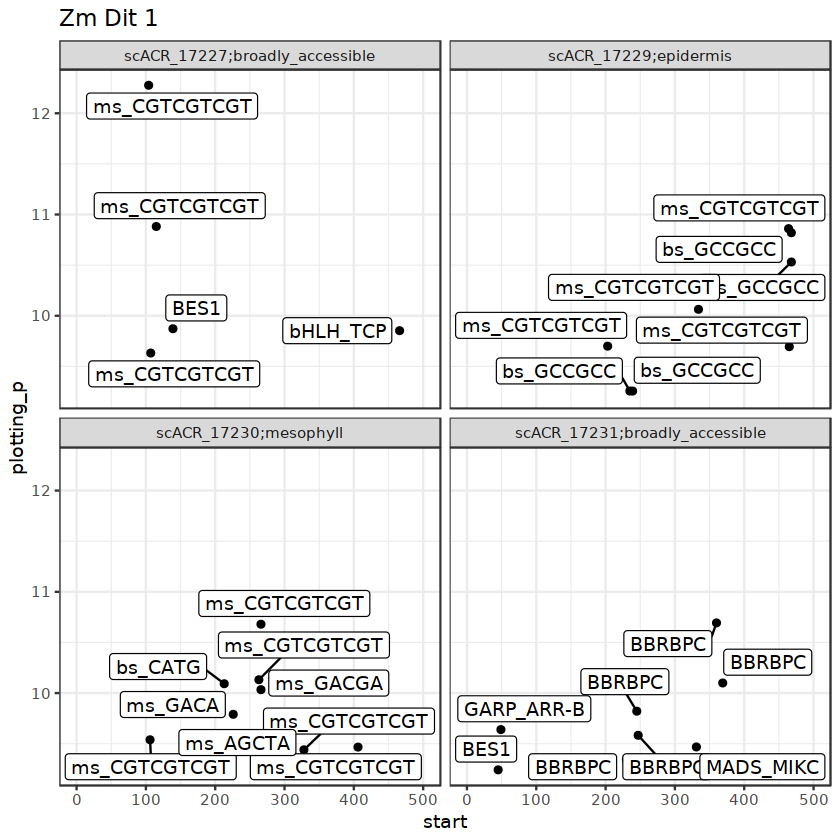

In [11]:
library(ggrepel)
library(cowplot)

sb_dit_1_scores <- combined_fimo_hits_info %>% 
    dplyr::filter(species == "Sb" & locus == "Sb__DIT_1") %>% 
    dplyr::rename(pval = "p-value") %>% 
    dplyr::mutate(plotting_p = -log((pval)))

sb_dit_1_scores_plot <- ggplot(sb_dit_1_scores, aes(start, plotting_p)) + 
    xlim(0,500) + geom_point() + ggtitle("Sb Dit 1") +
    geom_label_repel(aes(label = motif_id)) +
    facet_wrap(acrID~.) + theme_bw()



zm_dit_1_scores_more <- combined_fimo_hits_info %>% 
    dplyr::filter(species == "Zm" & locus == "Zm__DIT_1") %>% 
    dplyr::rename(pval = "p-value") %>% 
    dplyr::mutate(plotting_p = -log((pval)))

Zm_dit_1_scores_plot <- ggplot(zm_dit_1_scores_more, aes(start, plotting_p)) + 
    xlim(0,500) + geom_point() + ggtitle("Zm Dit 1") +
    geom_label_repel(aes(label = motif_id)) +
    facet_wrap(acrID~.) + theme_bw()

sb_dit_1_scores_plot
Zm_dit_1_scores_plot



In [38]:
ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Zm.dit1_acrs.pdf", 
       plot = Zm_dit_1_scores_plot, device = "pdf", width = 10, height = 10)
ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit1_acrs.pdf", 
       plot = sb_dit_1_scores_plot, device = "pdf", width = 15, height = 15)


In [13]:
library(ggrepel)
library(cowplot)

sb_dit_3_scores <- combined_fimo_hits_info %>% 
    dplyr::filter(species == "Sb" & locus == "Sb__DIT_3") %>% 
    dplyr::rename(pval = "p-value") %>% 
    dplyr::mutate(plotting_p = -log((pval)))

sb_dit_3_scores_plot <- ggplot(sb_dit_3_scores, aes(start, plotting_p)) + 
    xlim(0,500) + geom_point() + ggtitle("Sb Dit 3") +
    geom_label_repel(aes(label = motif_id)) +
    facet_wrap(acrID~.) + theme_bw()

sb_dit_4_scores <- combined_fimo_hits_info %>% 
    dplyr::filter(species == "Sb" & locus == "Sb__DIT_4") %>% 
    dplyr::rename(pval = "p-value") %>% 
    dplyr::mutate(plotting_p = -log((pval)))

sb_dit_4_scores_plot <- ggplot(sb_dit_4_scores, aes(start, plotting_p)) + 
    xlim(0,500) + geom_point() + ggtitle("Sb Dit 4") +
    geom_label_repel(aes(label = motif_id)) +
    facet_wrap(acrID~.) + theme_bw()


zm_dit_2_scores_more <- combined_fimo_hits_info %>% 
    dplyr::filter(species == "Zm" & locus == "Zm__DIT_2") %>% 
    dplyr::rename(pval = "p-value") %>% 
    dplyr::mutate(plotting_p = -log((pval)))

Zm_dit_2_scores_plot <- ggplot(zm_dit_2_scores_more, aes(start, plotting_p)) + 
    xlim(0,500) + geom_point() + ggtitle("Zm Dit 2") +
    geom_label_repel(aes(label = motif_id)) +
    facet_wrap(acrID~.) + theme_bw()

ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Zm.dit2_acrs.pdf", 
       plot = Zm_dit_2_scores_plot, device = "pdf", width = 10, height = 5)
ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit3_acrs.pdf", 
       plot = sb_dit_3_scores_plot, device = "pdf", width = 15, height = 5)
ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit4_acrs.pdf", 
       plot = sb_dit_4_scores_plot, device = "pdf", width = 10, height = 5)


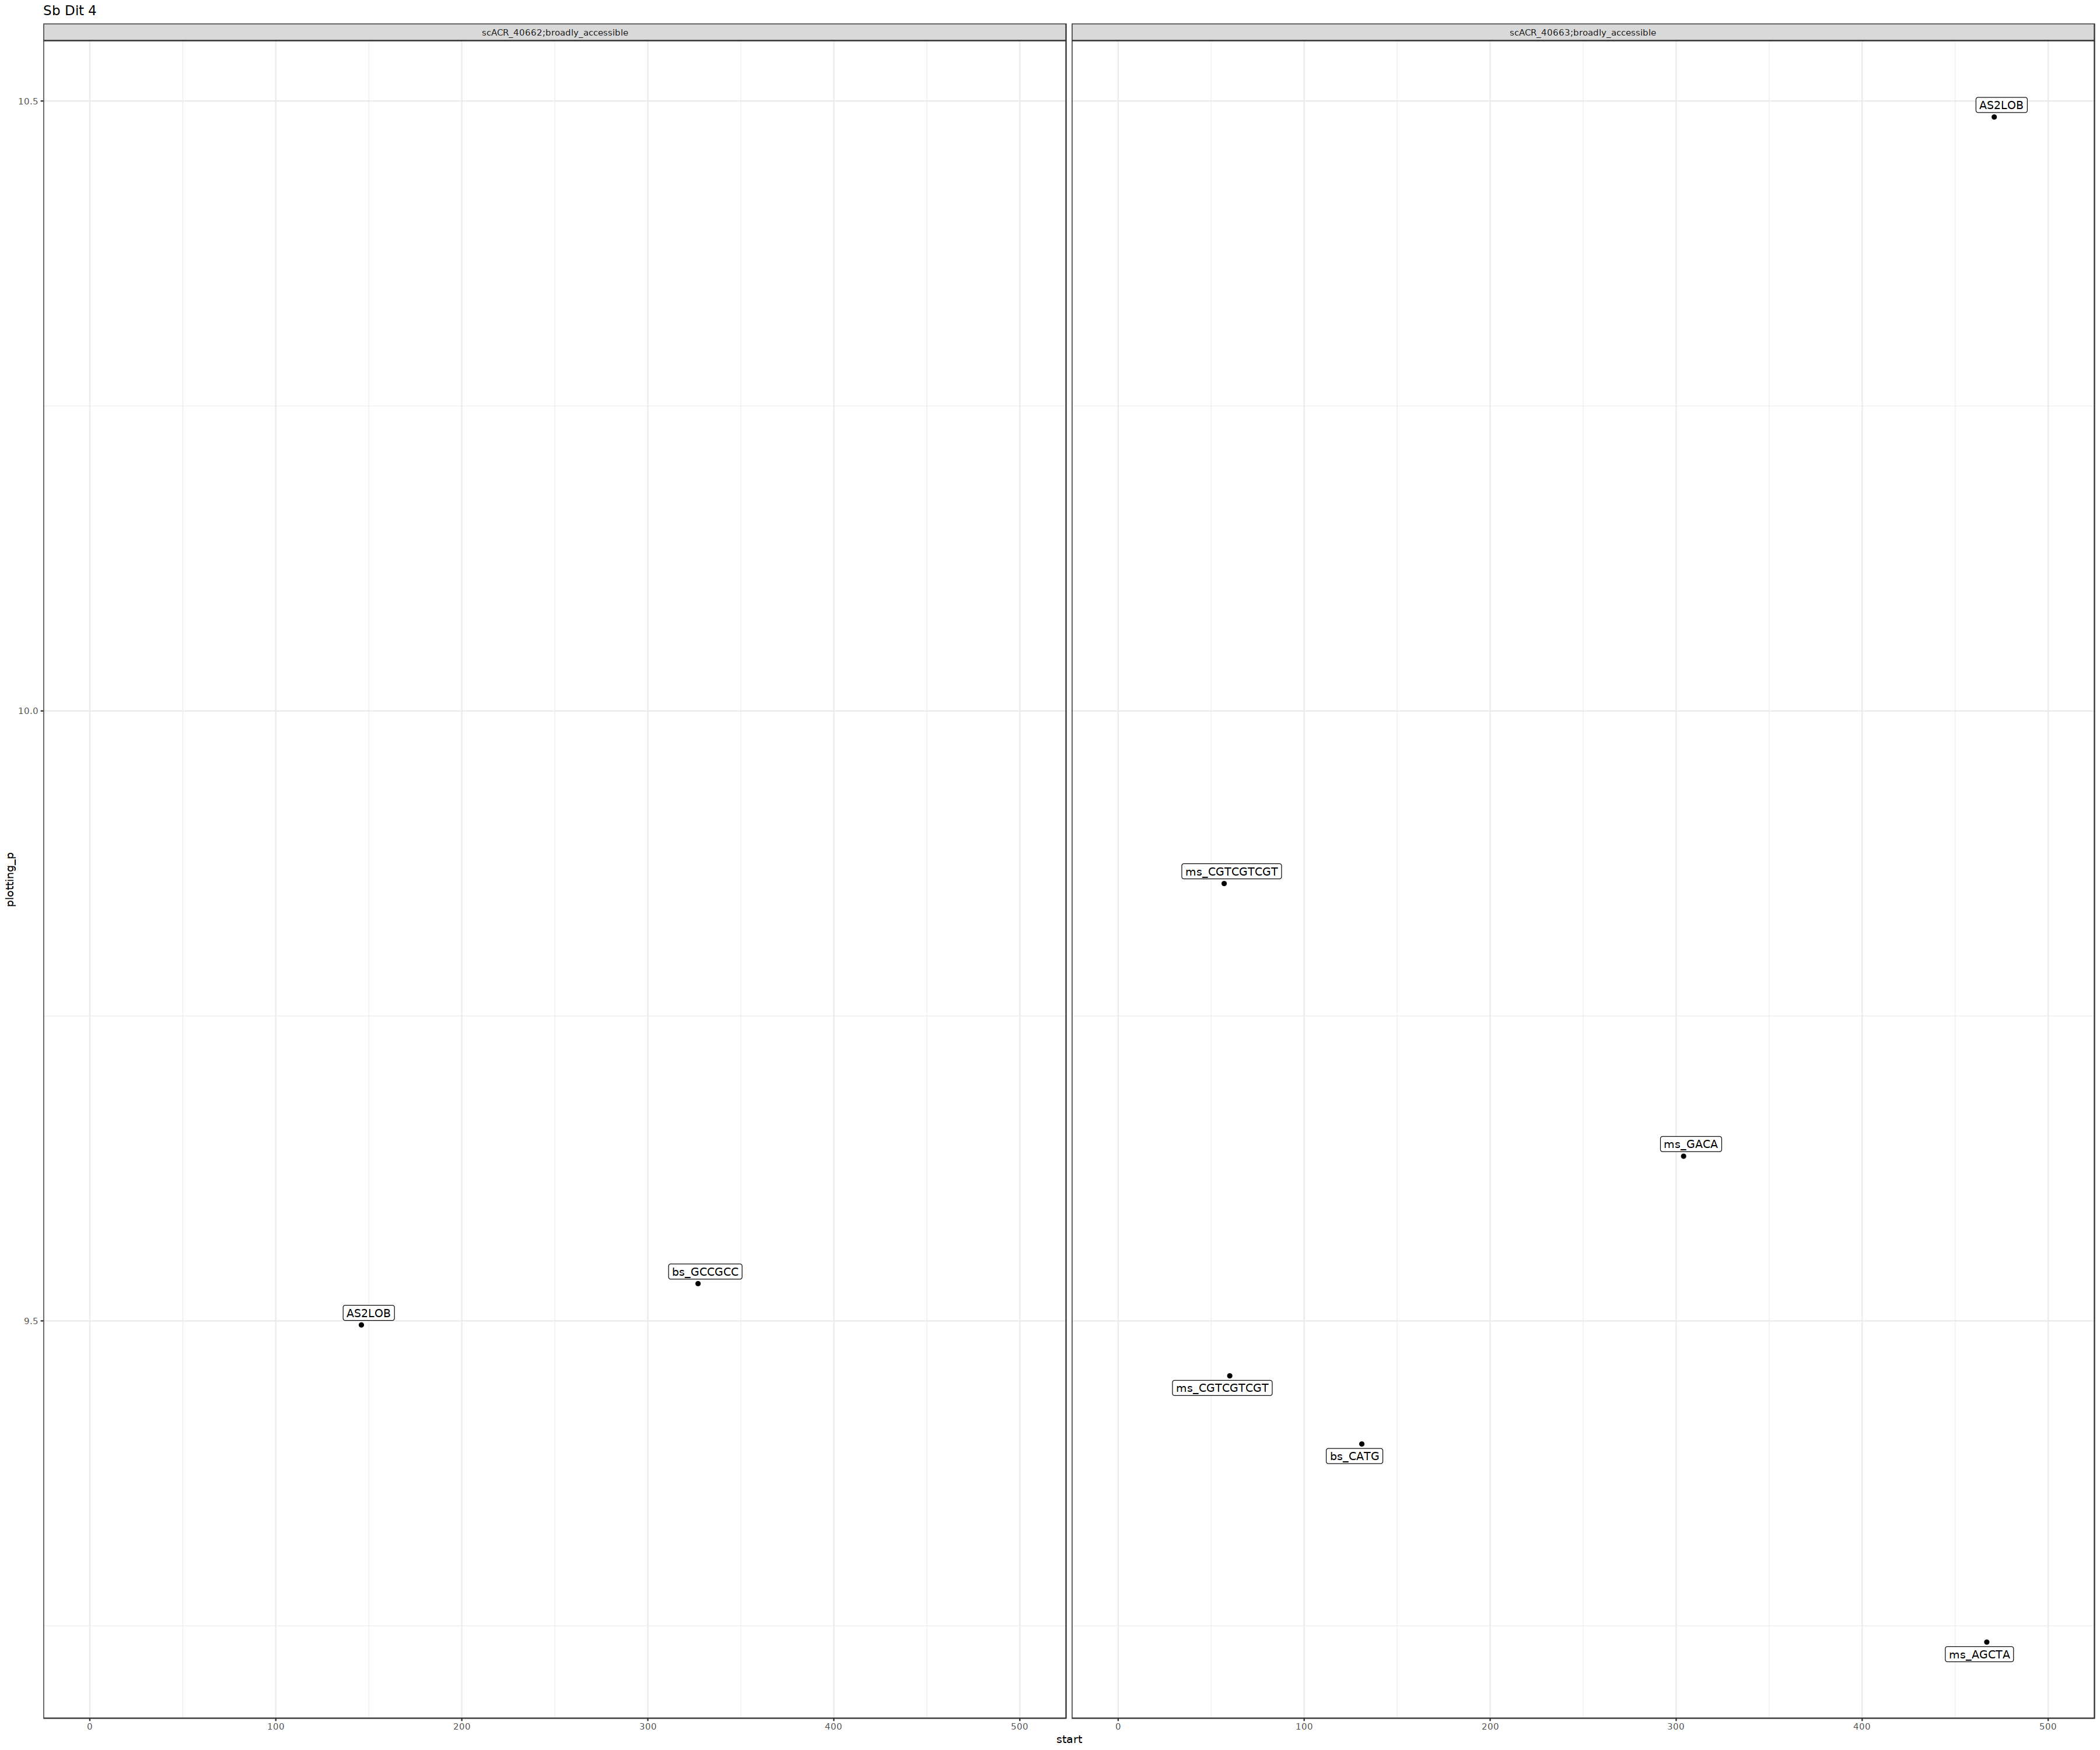

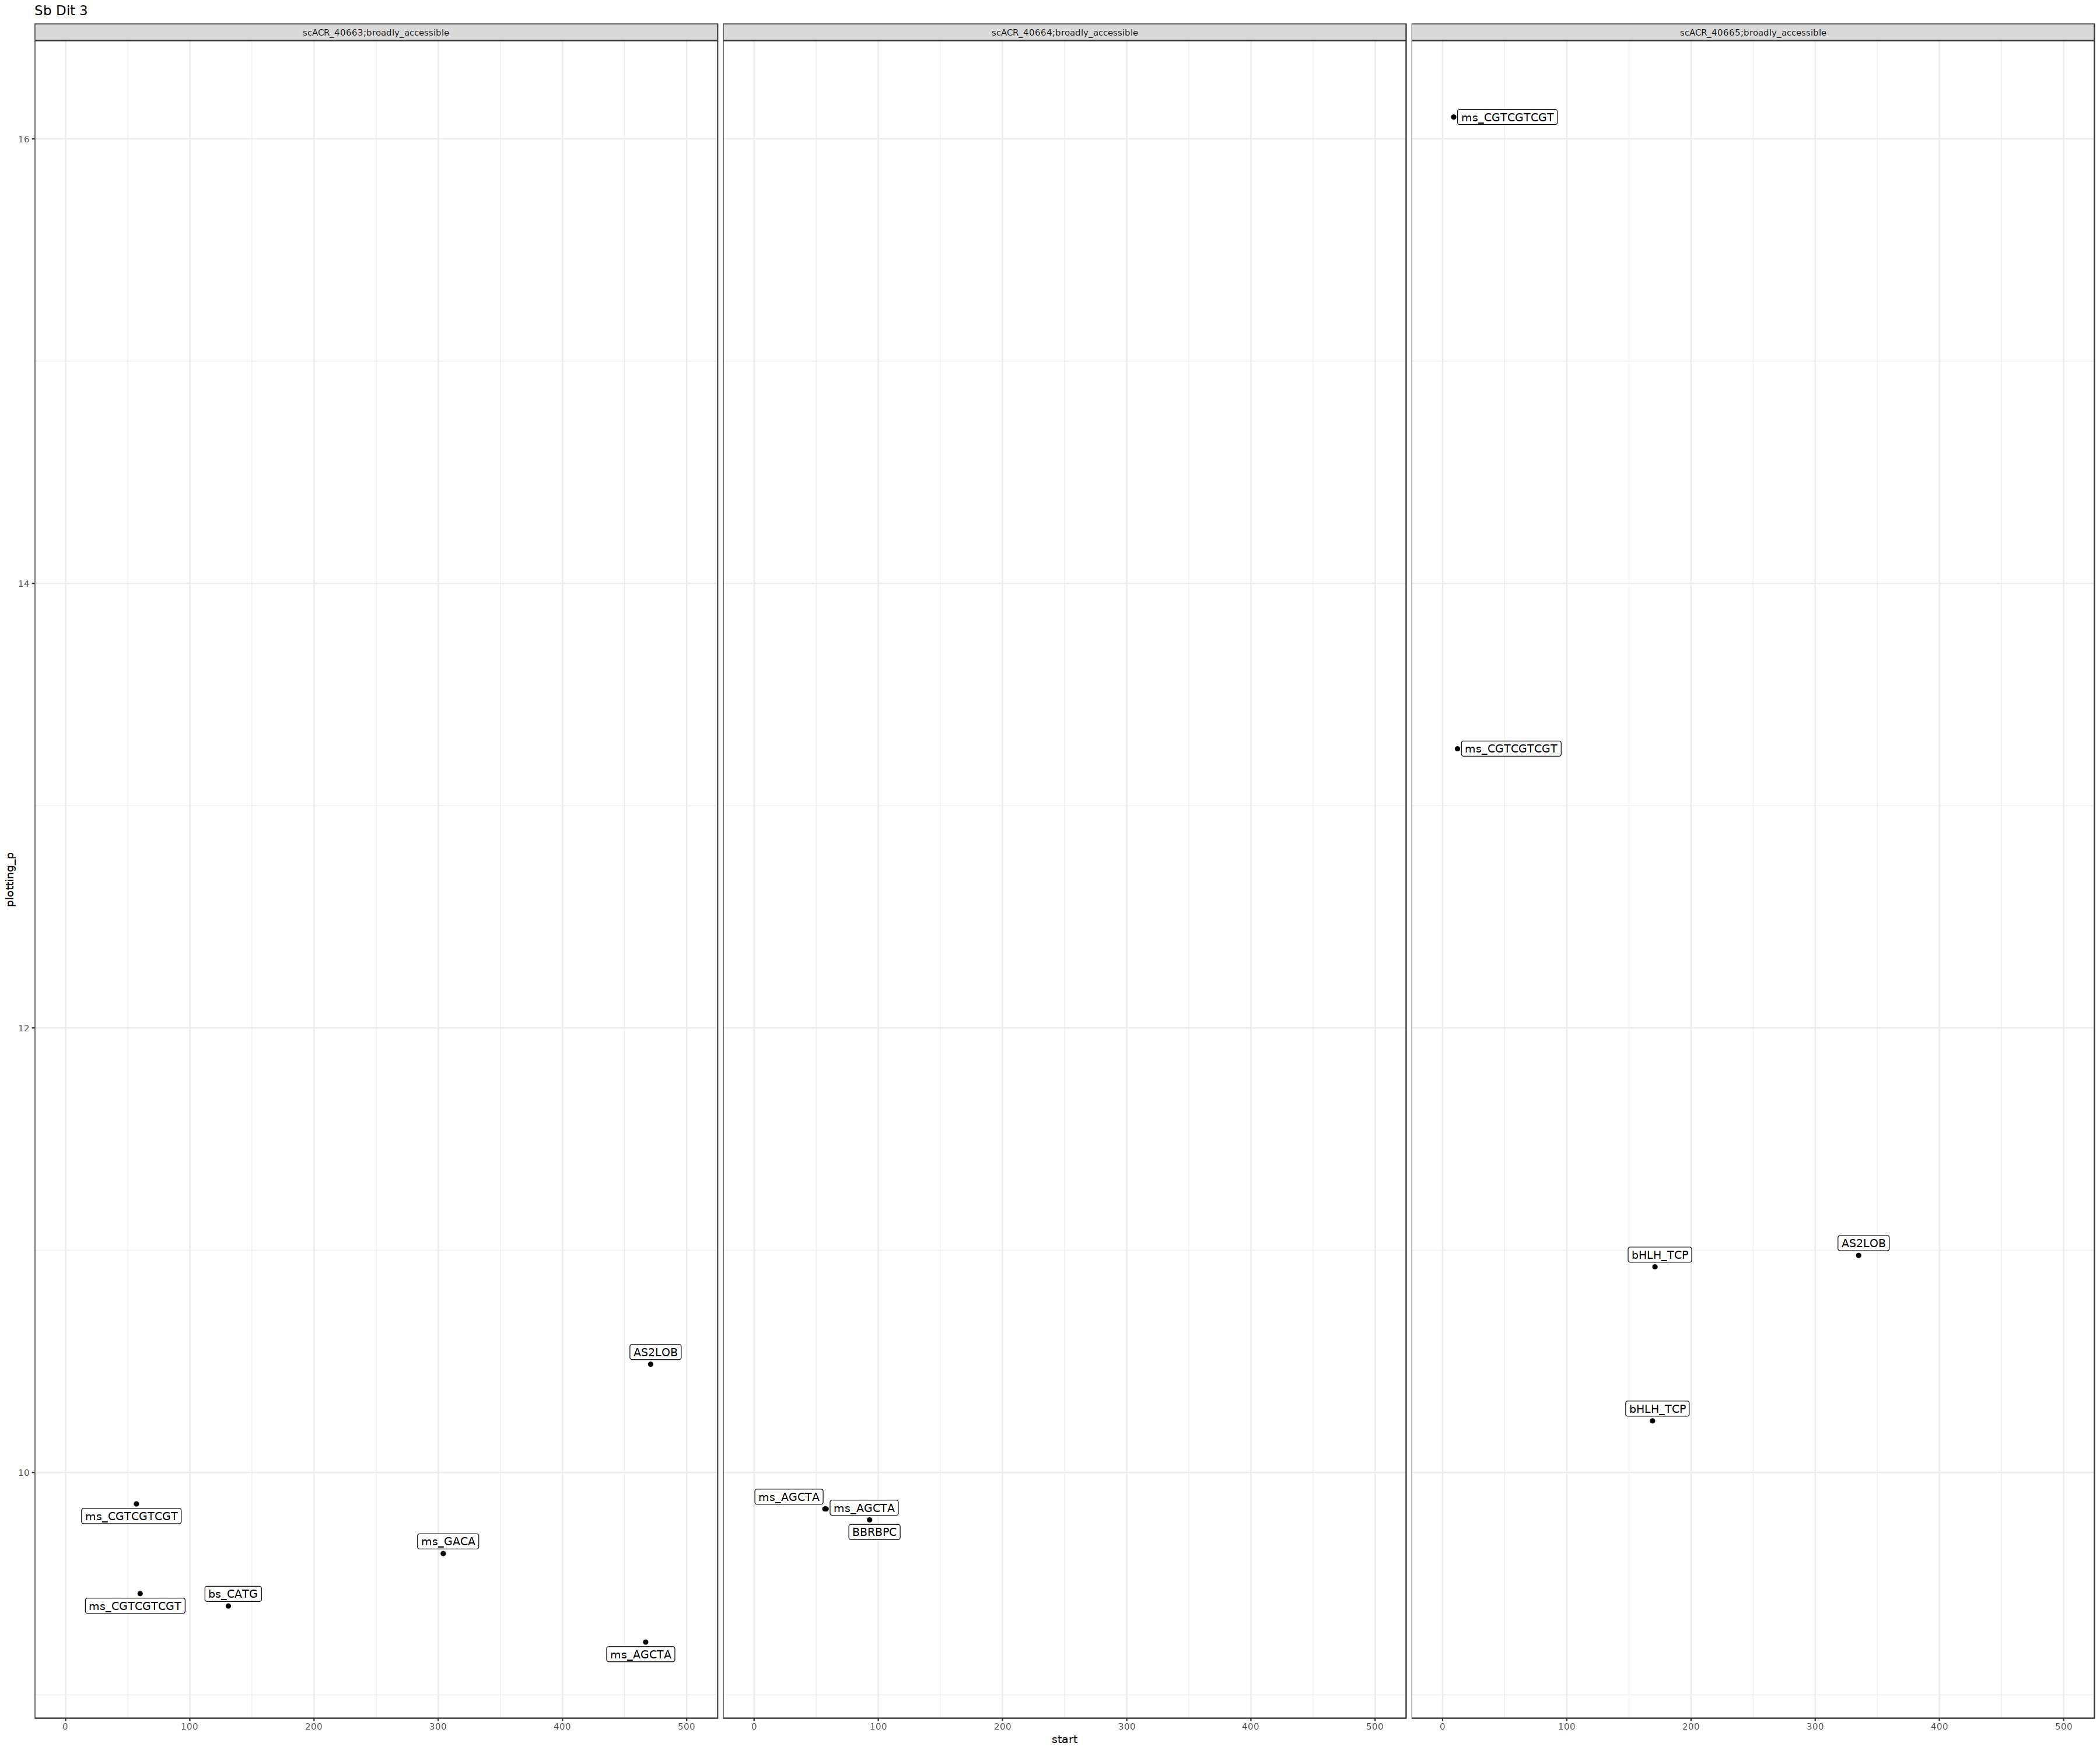

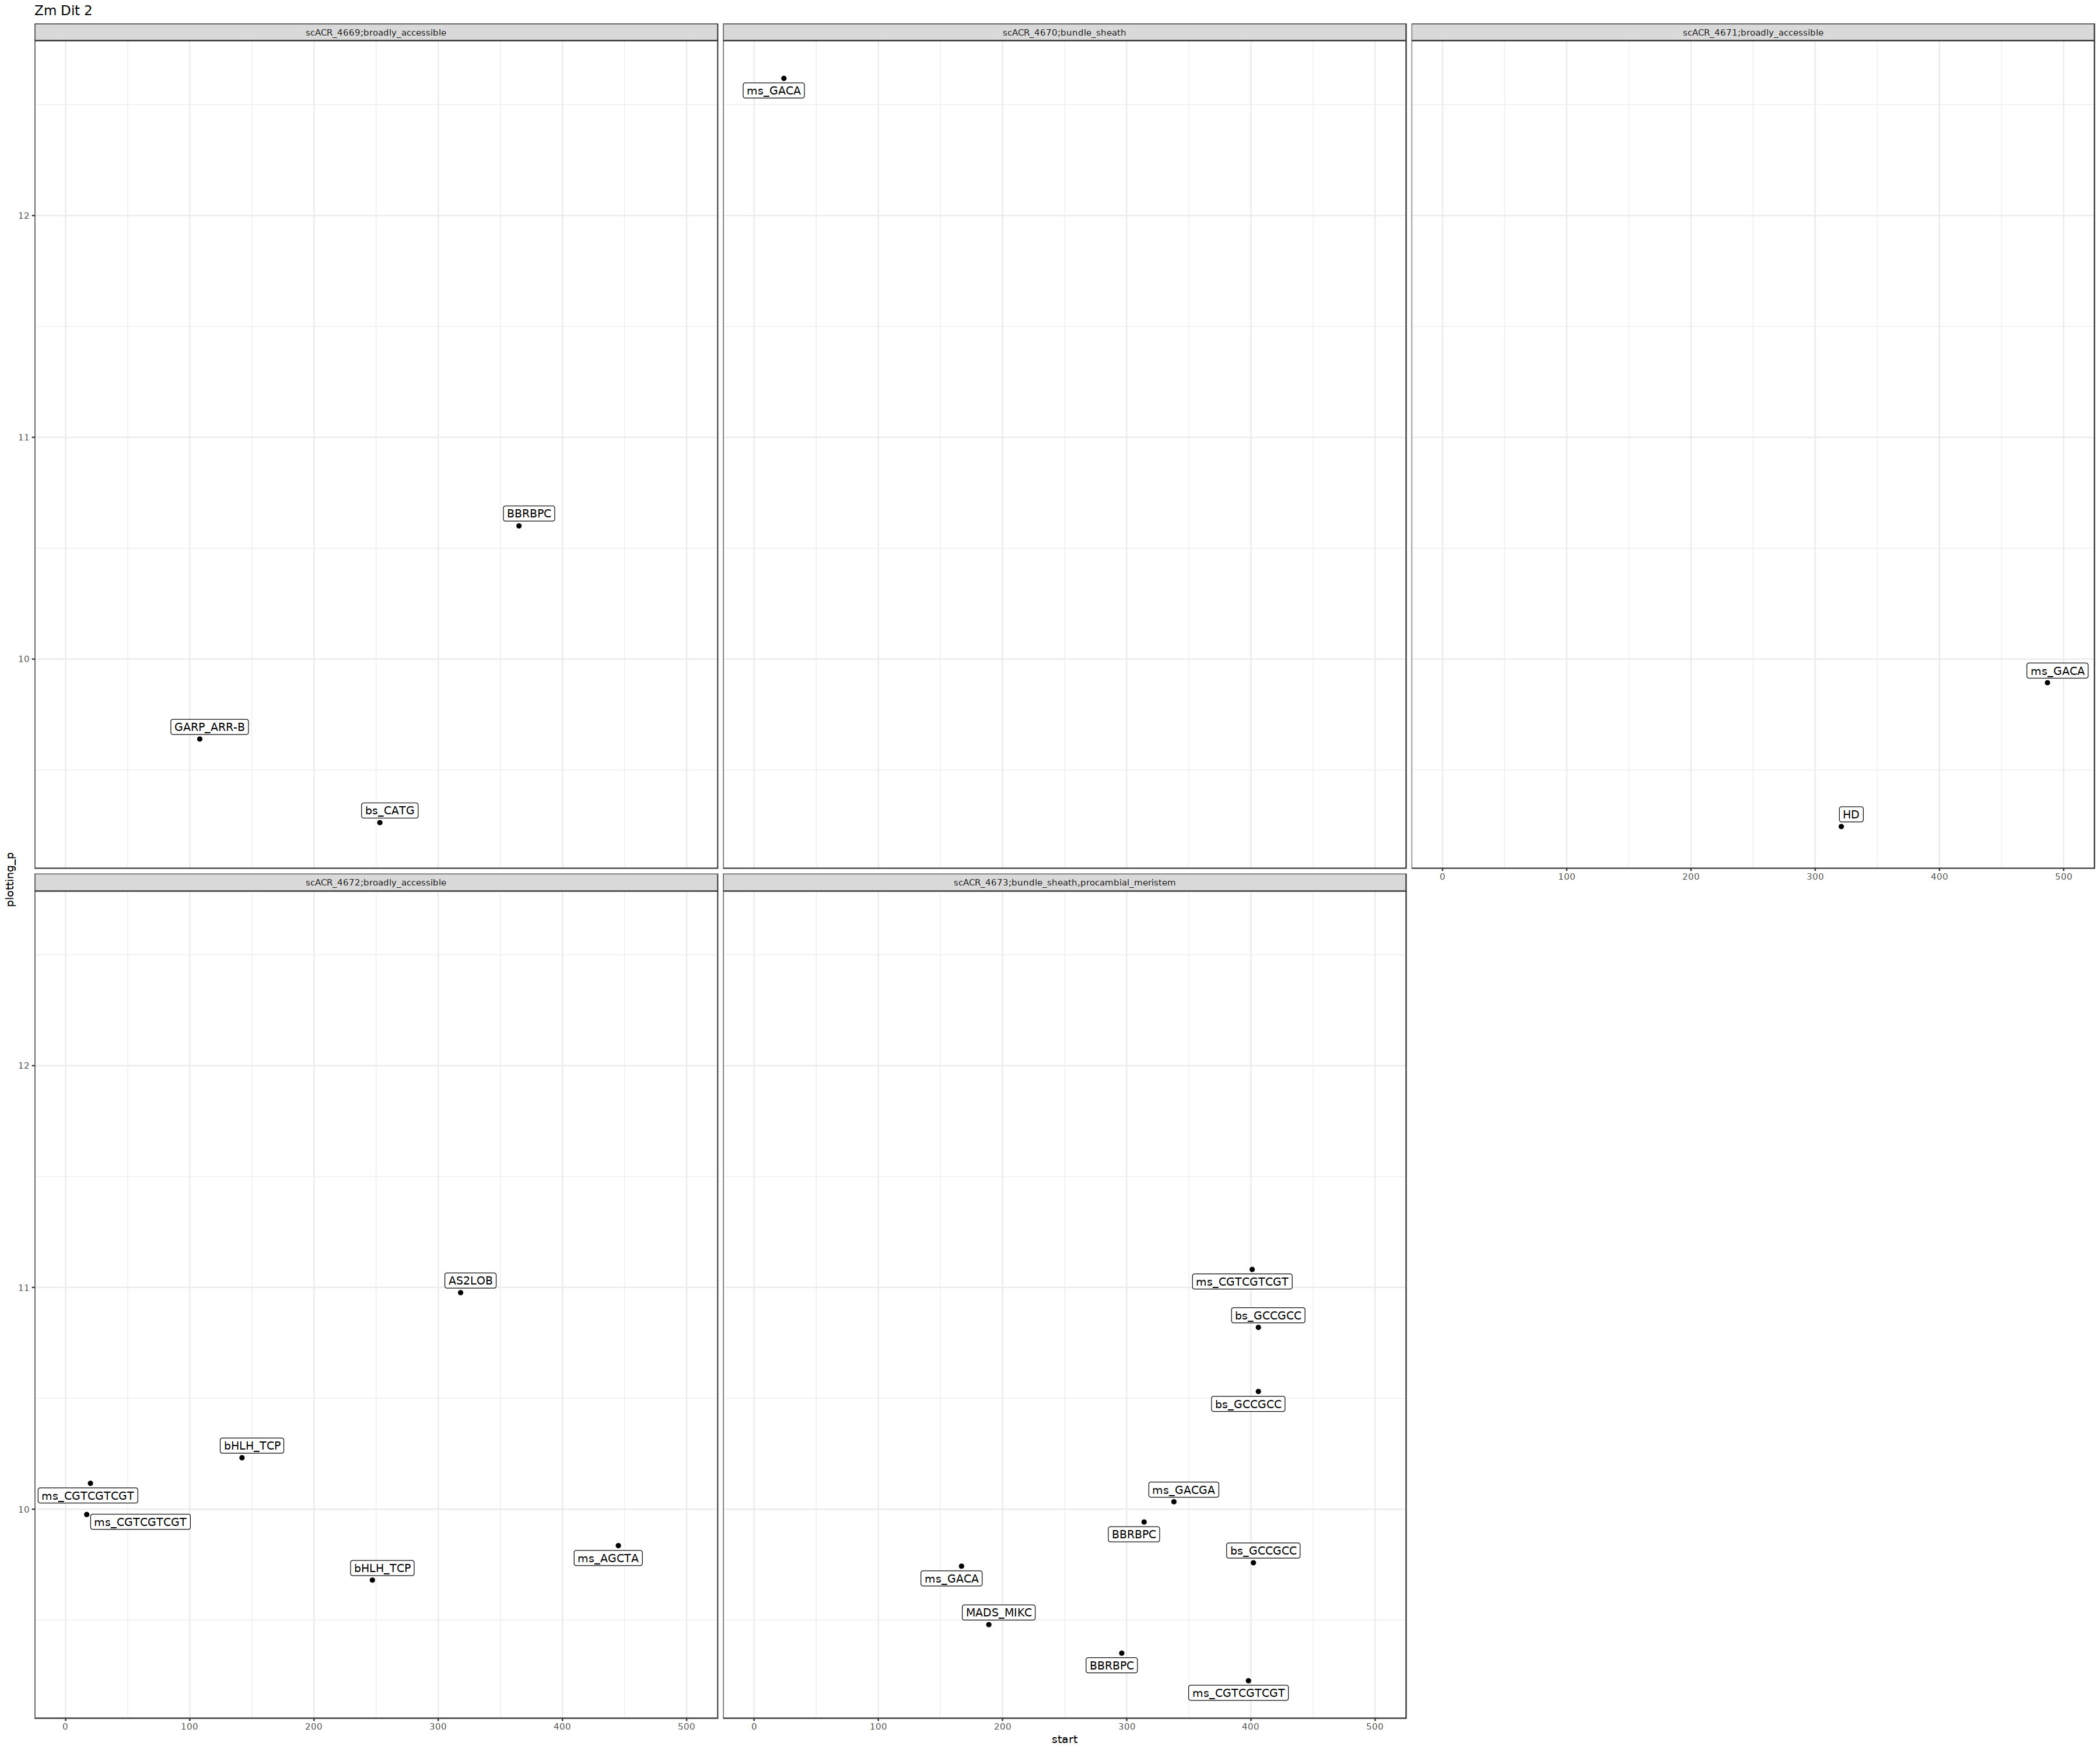

In [43]:
sb_dit_4_scores_plot
sb_dit_3_scores_plot
Zm_dit_2_scores_plot

In [14]:
unique(combined_fimo_hits_info$locus)

[1] "Zm__DIT_2" "Zm__DIT_1" "Sb__DIT_1" "Sb__DIT_2" "Sb__DIT_3" "Sb__DIT_4"

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


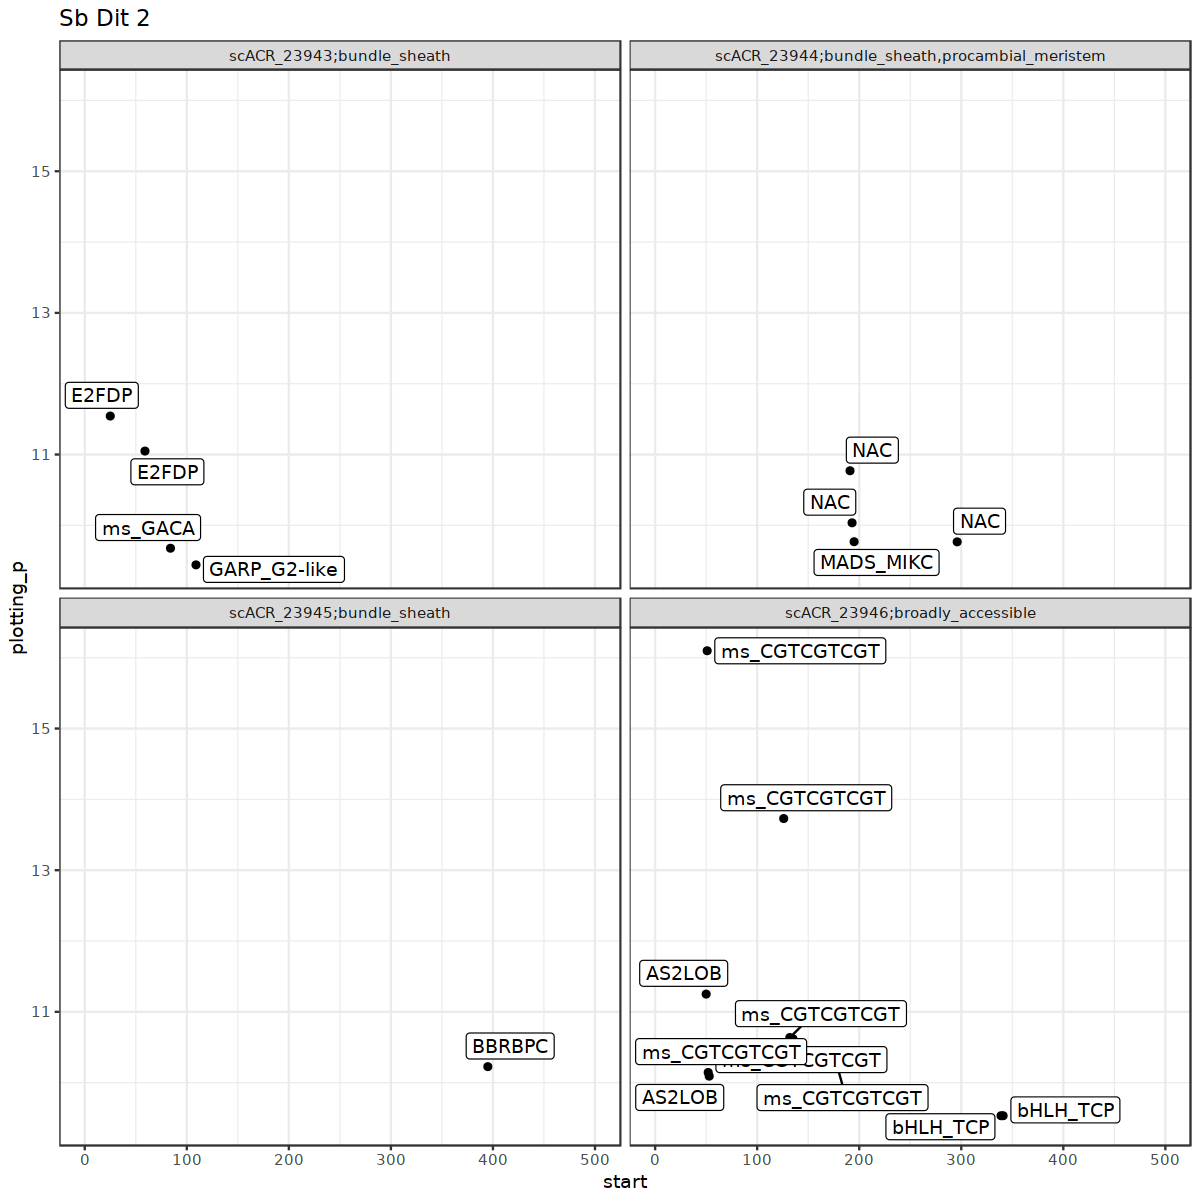

In [15]:

sb_dit_2_scores_all <- combined_fimo_hits_info %>% 
    dplyr::filter(species == "Sb" & locus == "Sb__DIT_2") %>% 
    dplyr::rename(pval = "p-value") %>% 
    dplyr::mutate(plotting_p = -log((pval)))

options(repr.plot.width=10, repr.plot.height=10)
sb_dit_2_scores_plot <- ggplot(sb_dit_2_scores_all, aes(start, plotting_p)) + 
    xlim(0,500) + geom_point() + 
    geom_label_repel(aes(label = motif_id)) +
    facet_wrap(acrID~.) + theme_bw() + ggtitle("Sb Dit 2") 
sb_dit_2_scores_plot

ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit2_acrs.pdf", 
       plot = sb_dit_4_scores_plot, device = "pdf", width = 10, height = 10)


`summarise()` has grouped output by 'species', 'locus'. You can override using
the `.groups` argument.


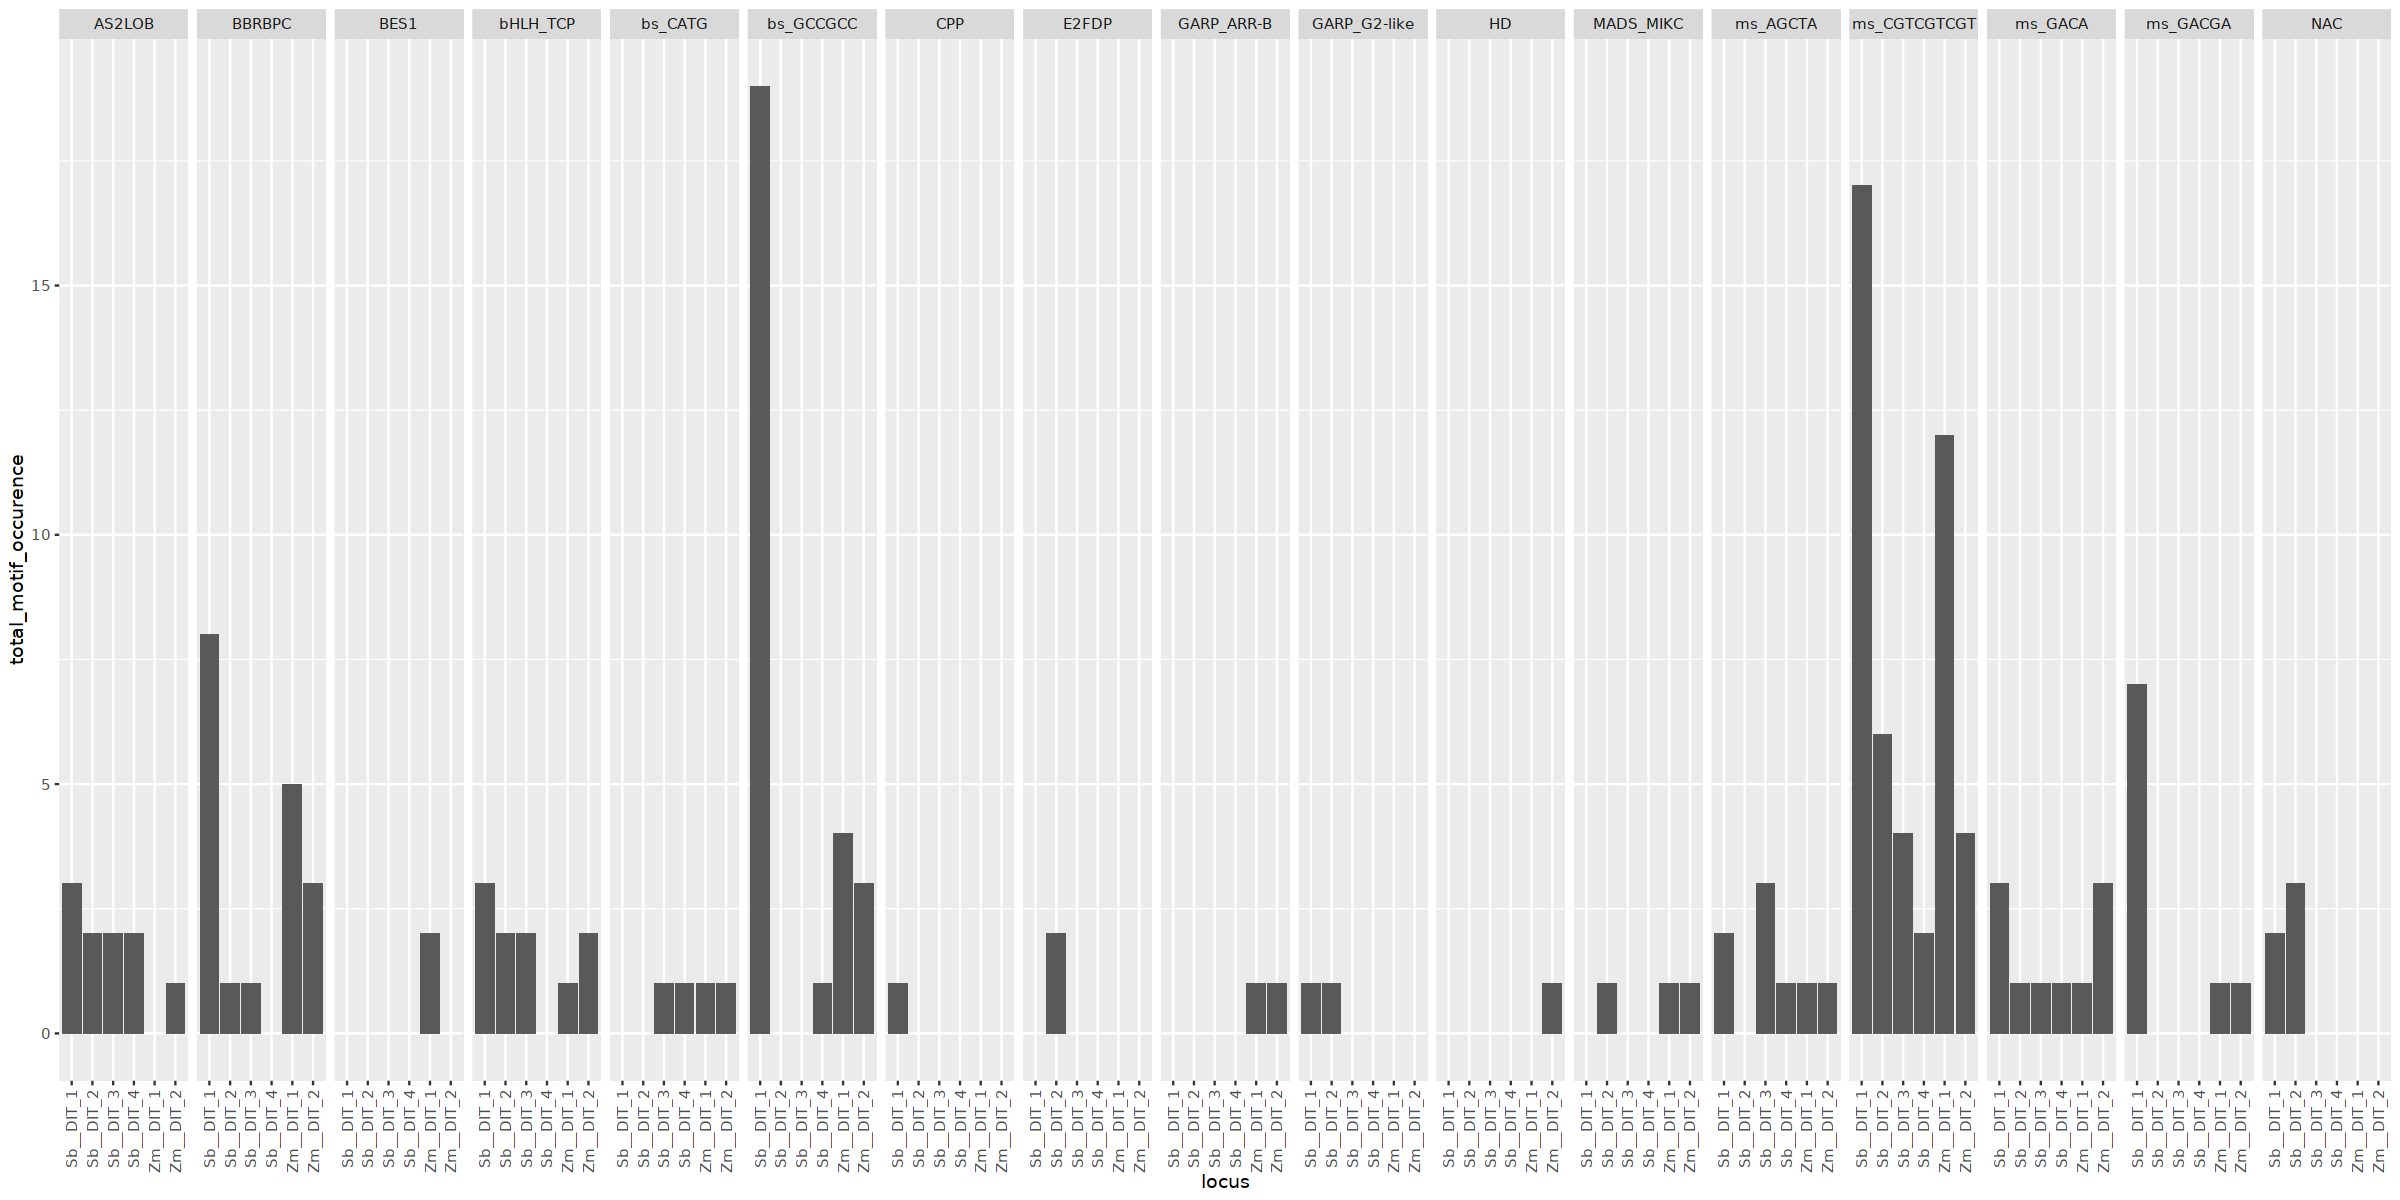

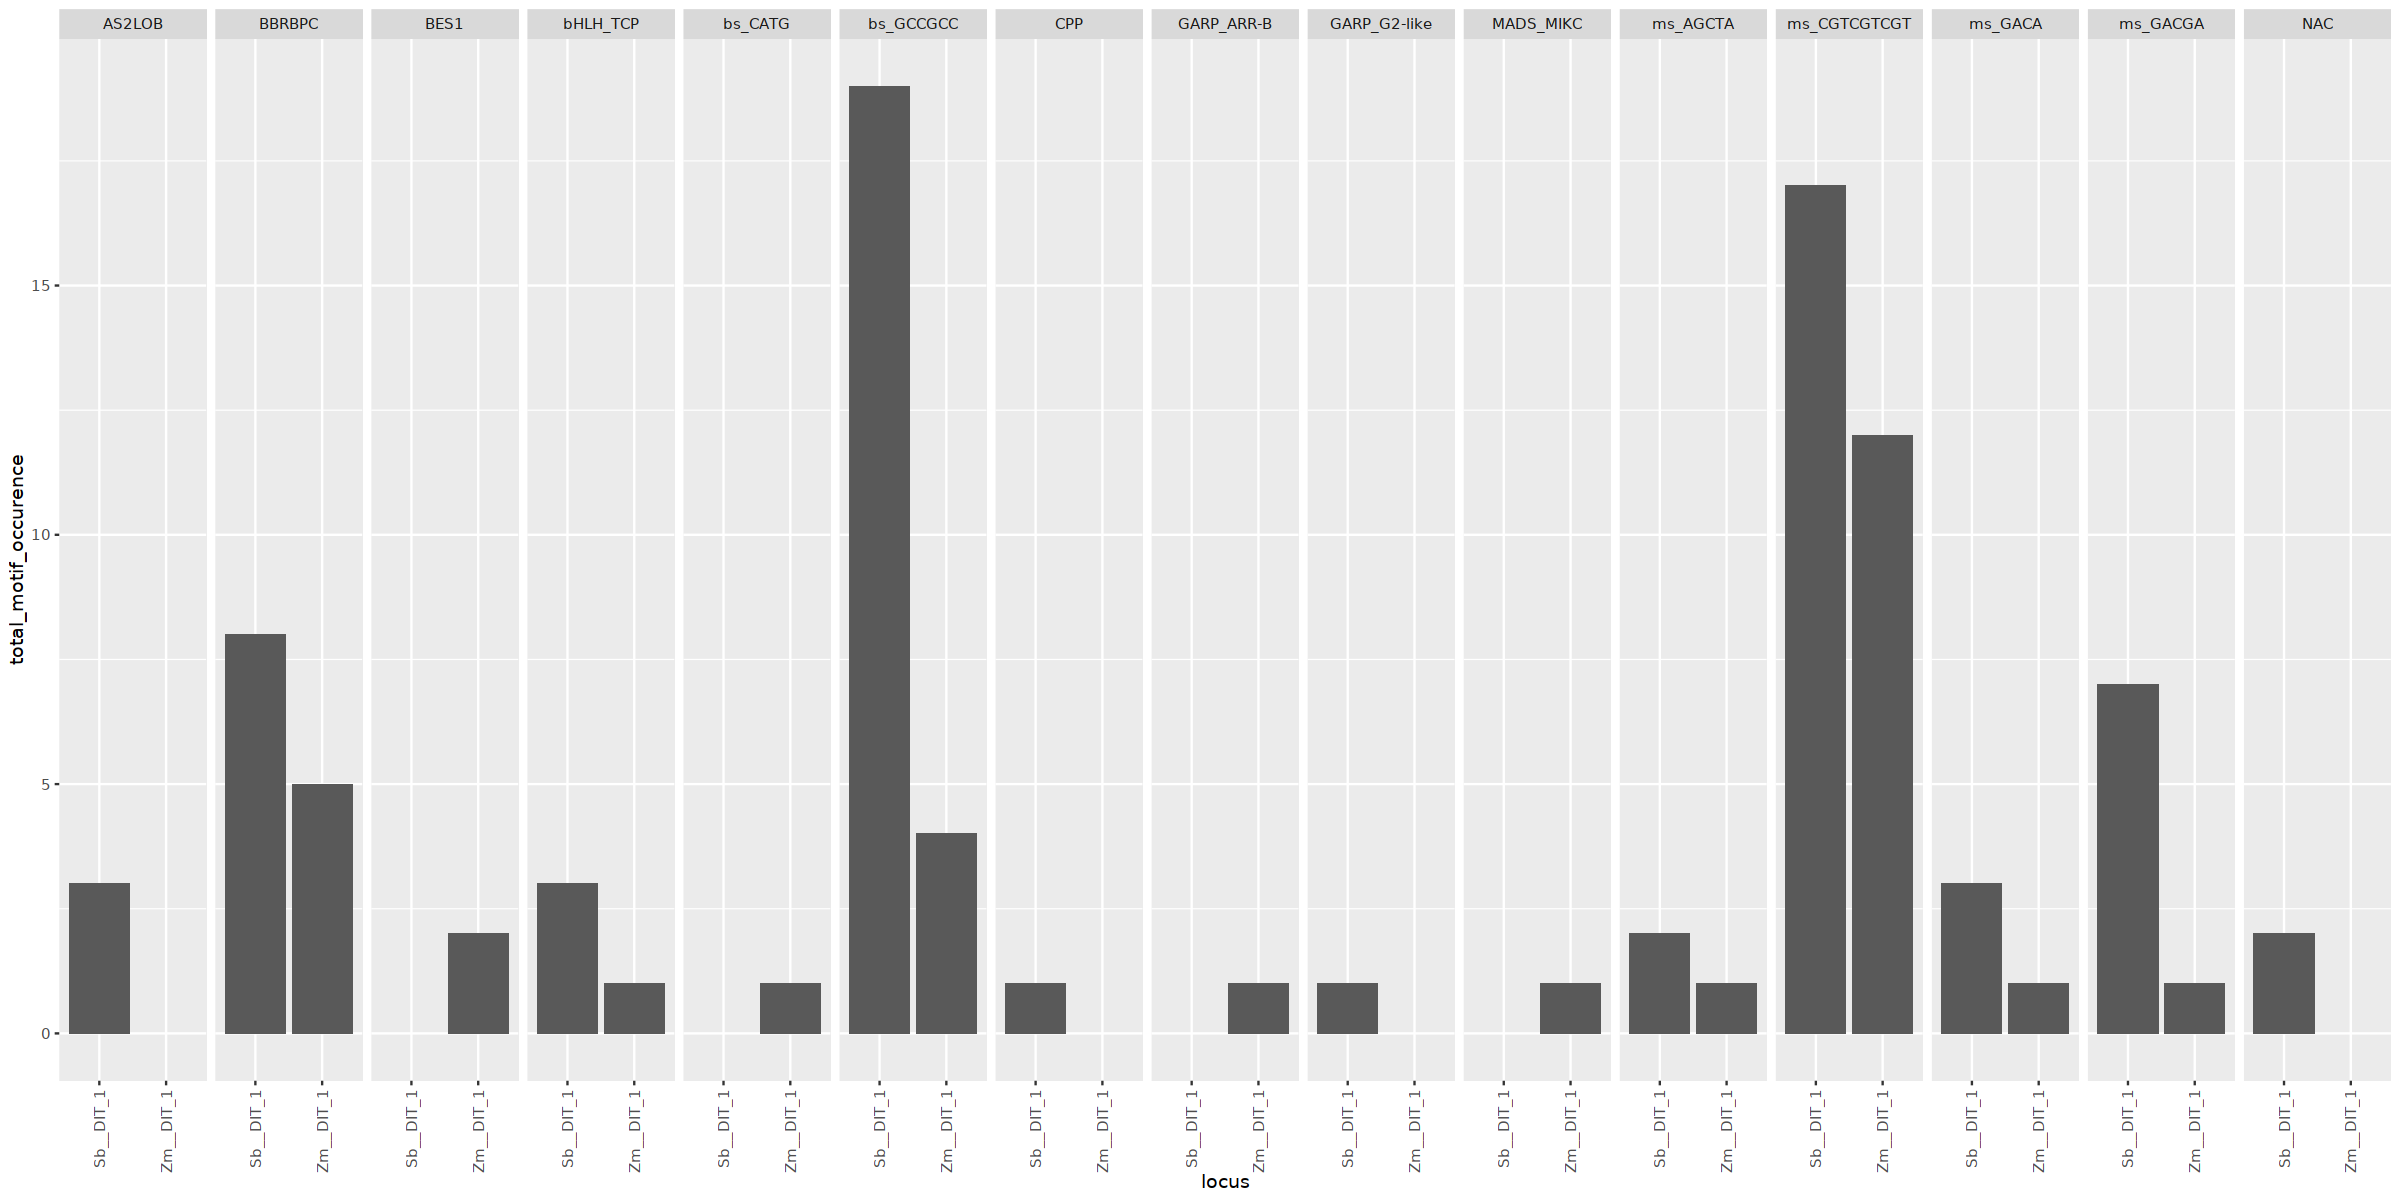

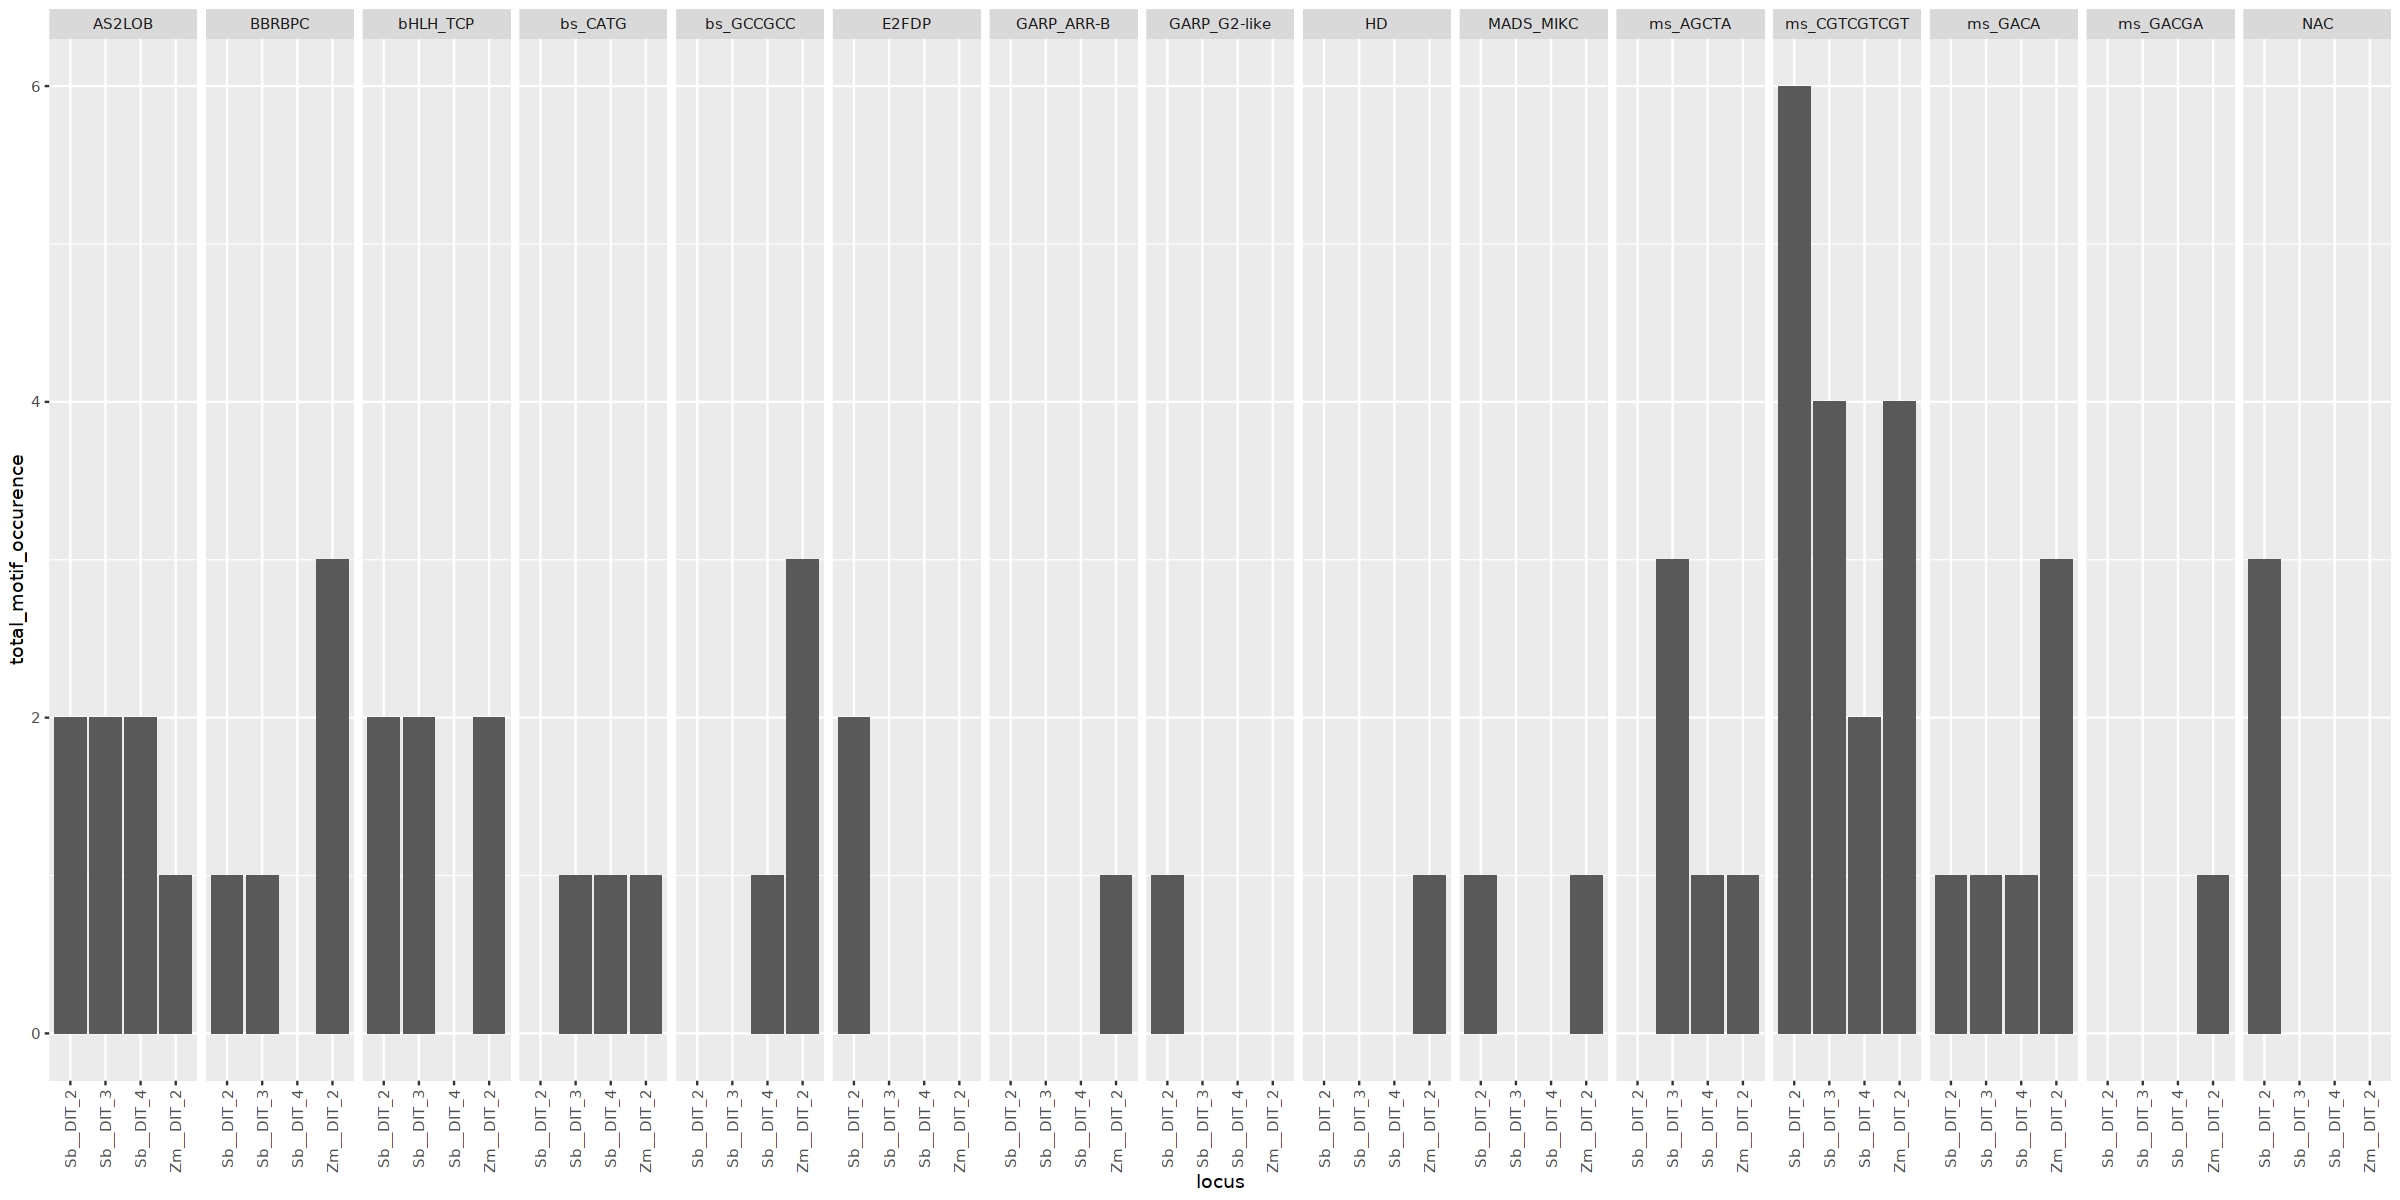

In [16]:
motif_dit_counts <- combined_fimo_hits_info %>% 
    dplyr::group_by(species, locus, motif_id) %>% 
    dplyr::summarise(total_motif_occurence = n())

options(repr.plot.width=20, repr.plot.height=10)

ggplot(motif_dit_counts, aes(x = locus, y = total_motif_occurence)) + 
    geom_bar(stat="identity") + 
    facet_grid(. ~ motif_id) +
 theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


motif_dit_counts %>% 
    dplyr::filter(locus %in% c("Sb__DIT_1", "Zm__DIT_1")) %>% 
    ggplot(., aes(x = locus, y = total_motif_occurence)) + 
    geom_bar(stat="identity") + 
    facet_grid(. ~ motif_id) +
 theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

motif_dit_counts %>% 
    dplyr::filter(locus %in% c("Sb__DIT_2", "Sb__DIT_3", "Sb__DIT_4", "Zm__DIT_2")) %>% 
    ggplot(., aes(x = locus, y = total_motif_occurence)) + 
    geom_bar(stat="identity") + 
    facet_grid(. ~ motif_id) +
 theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [17]:
w_cell_type <- motif_dit_counts %>% 
    dplyr::mutate(cell_type = case_when(locus %in% c("Sb__DIT_2", "Sb__DIT_3", "Sb__DIT_4", "Zm__DIT_2") ~ "BS",
                                       TRUE ~ "MS")) %>% 
    dplyr::filter(locus %in% c("Sb__DIT_1", "Sb__DIT_2", "Zm__DIT_1", "Zm__DIT_2"))


In [18]:
library(ggpubr)



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be incorrect”
Warning message:
“Computation failed in `stat_signif()`
Caused by error in `chisq.test()`:
! 'x' must at least have 2 elements”
Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be incorrect”
Warning message:
“Computation failed in `stat_signif()`
Caused by error in `chisq.test()`:
! 'x' must at least have 2 elements”
Warning message:
“Computation failed in `stat_signif()`
Caused by error in `chisq.test()`:
! 'x' must at least have 2 elements”
Warning message in chisq.test(cbind(a, b)):
“Chi-squared approximation may be inco

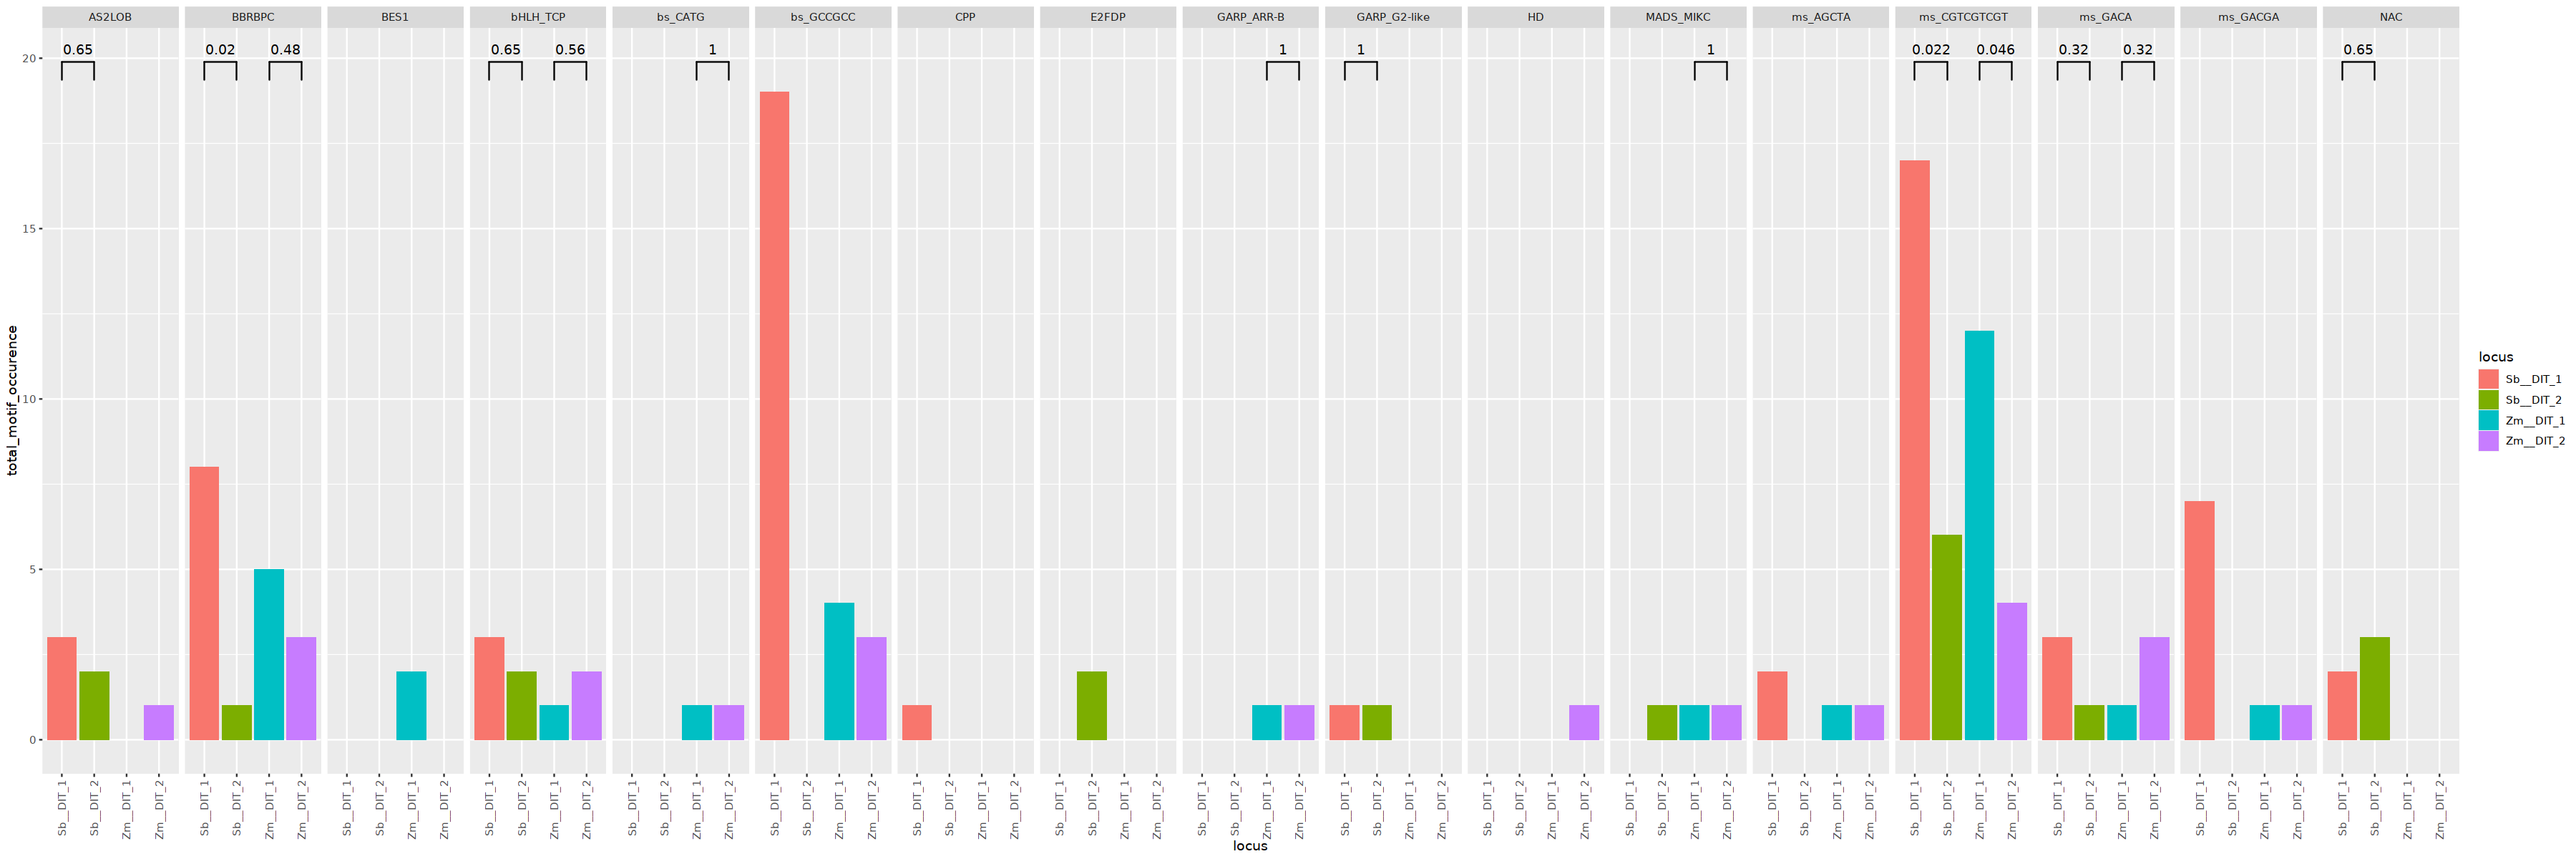

In [21]:
chi.test <- function(a, b) {
  return(chisq.test(cbind(a, b)))
}

options(repr.plot.width=30, repr.plot.height=10)

ggplot(w_cell_type, aes(x = locus, y = total_motif_occurence, fill = locus))+
    geom_bar(stat="identity") + 
    geom_signif(comparisons = list(c("Sb__DIT_1","Sb__DIT_2"), c("Zm__DIT_1","Zm__DIT_2")), 
              test = "chi.test") +
    facet_grid(. ~ motif_id) +
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [22]:
fimo_null_values <- fimo_binding_regions_all %>% 
    dplyr::filter(type == "broadly_accessible")

In [23]:
library(progress)

In [24]:
# Function to take a sample and count motifs, now including species as a parameter
sample_and_count_motifs <- function(acr_count, species, df) {
  acr_names <- df %>% 
    filter(species == species) %>%  # Filter by species
    sample_n(acr_count) 
    
  final <- df %>% 
    dplyr::filter(species == species & acr %in% acr_names$acr) %>% 
    dplyr::group_by(motif_id) %>% 
    dplyr::summarise(motif_count = n())
    
  return(final)
}

# Function to repeat sampling 5,000 times for a given acr_count and species
repeat_sampling_for_loci <- function(acr_count, species) {
  map_df(1:1000, ~sample_and_count_motifs(acr_count, species, fimo_null_values))
}

# Apply repeat_sampling_for_loci to each row in dit_number_species
final_results <- dit_number_species %>%
  group_by(locus, species) %>%
  mutate(samples = map2(acr_count, species, ~repeat_sampling_for_loci(.x, .y)))

# # Optional: Combine all results into one data frame
# final_results <- bind_rows(results$samples)

In [25]:
for_plotting_density <- motif_dit_counts

In [26]:
null_values <- final_results %>% 
    unnest(samples) %>% 
    dplyr::mutate(sample_type = "null") %>% 
    dplyr::select(-acr_count)

Warning message:
“Removed 3912 rows containing non-finite values (`stat_density()`).”


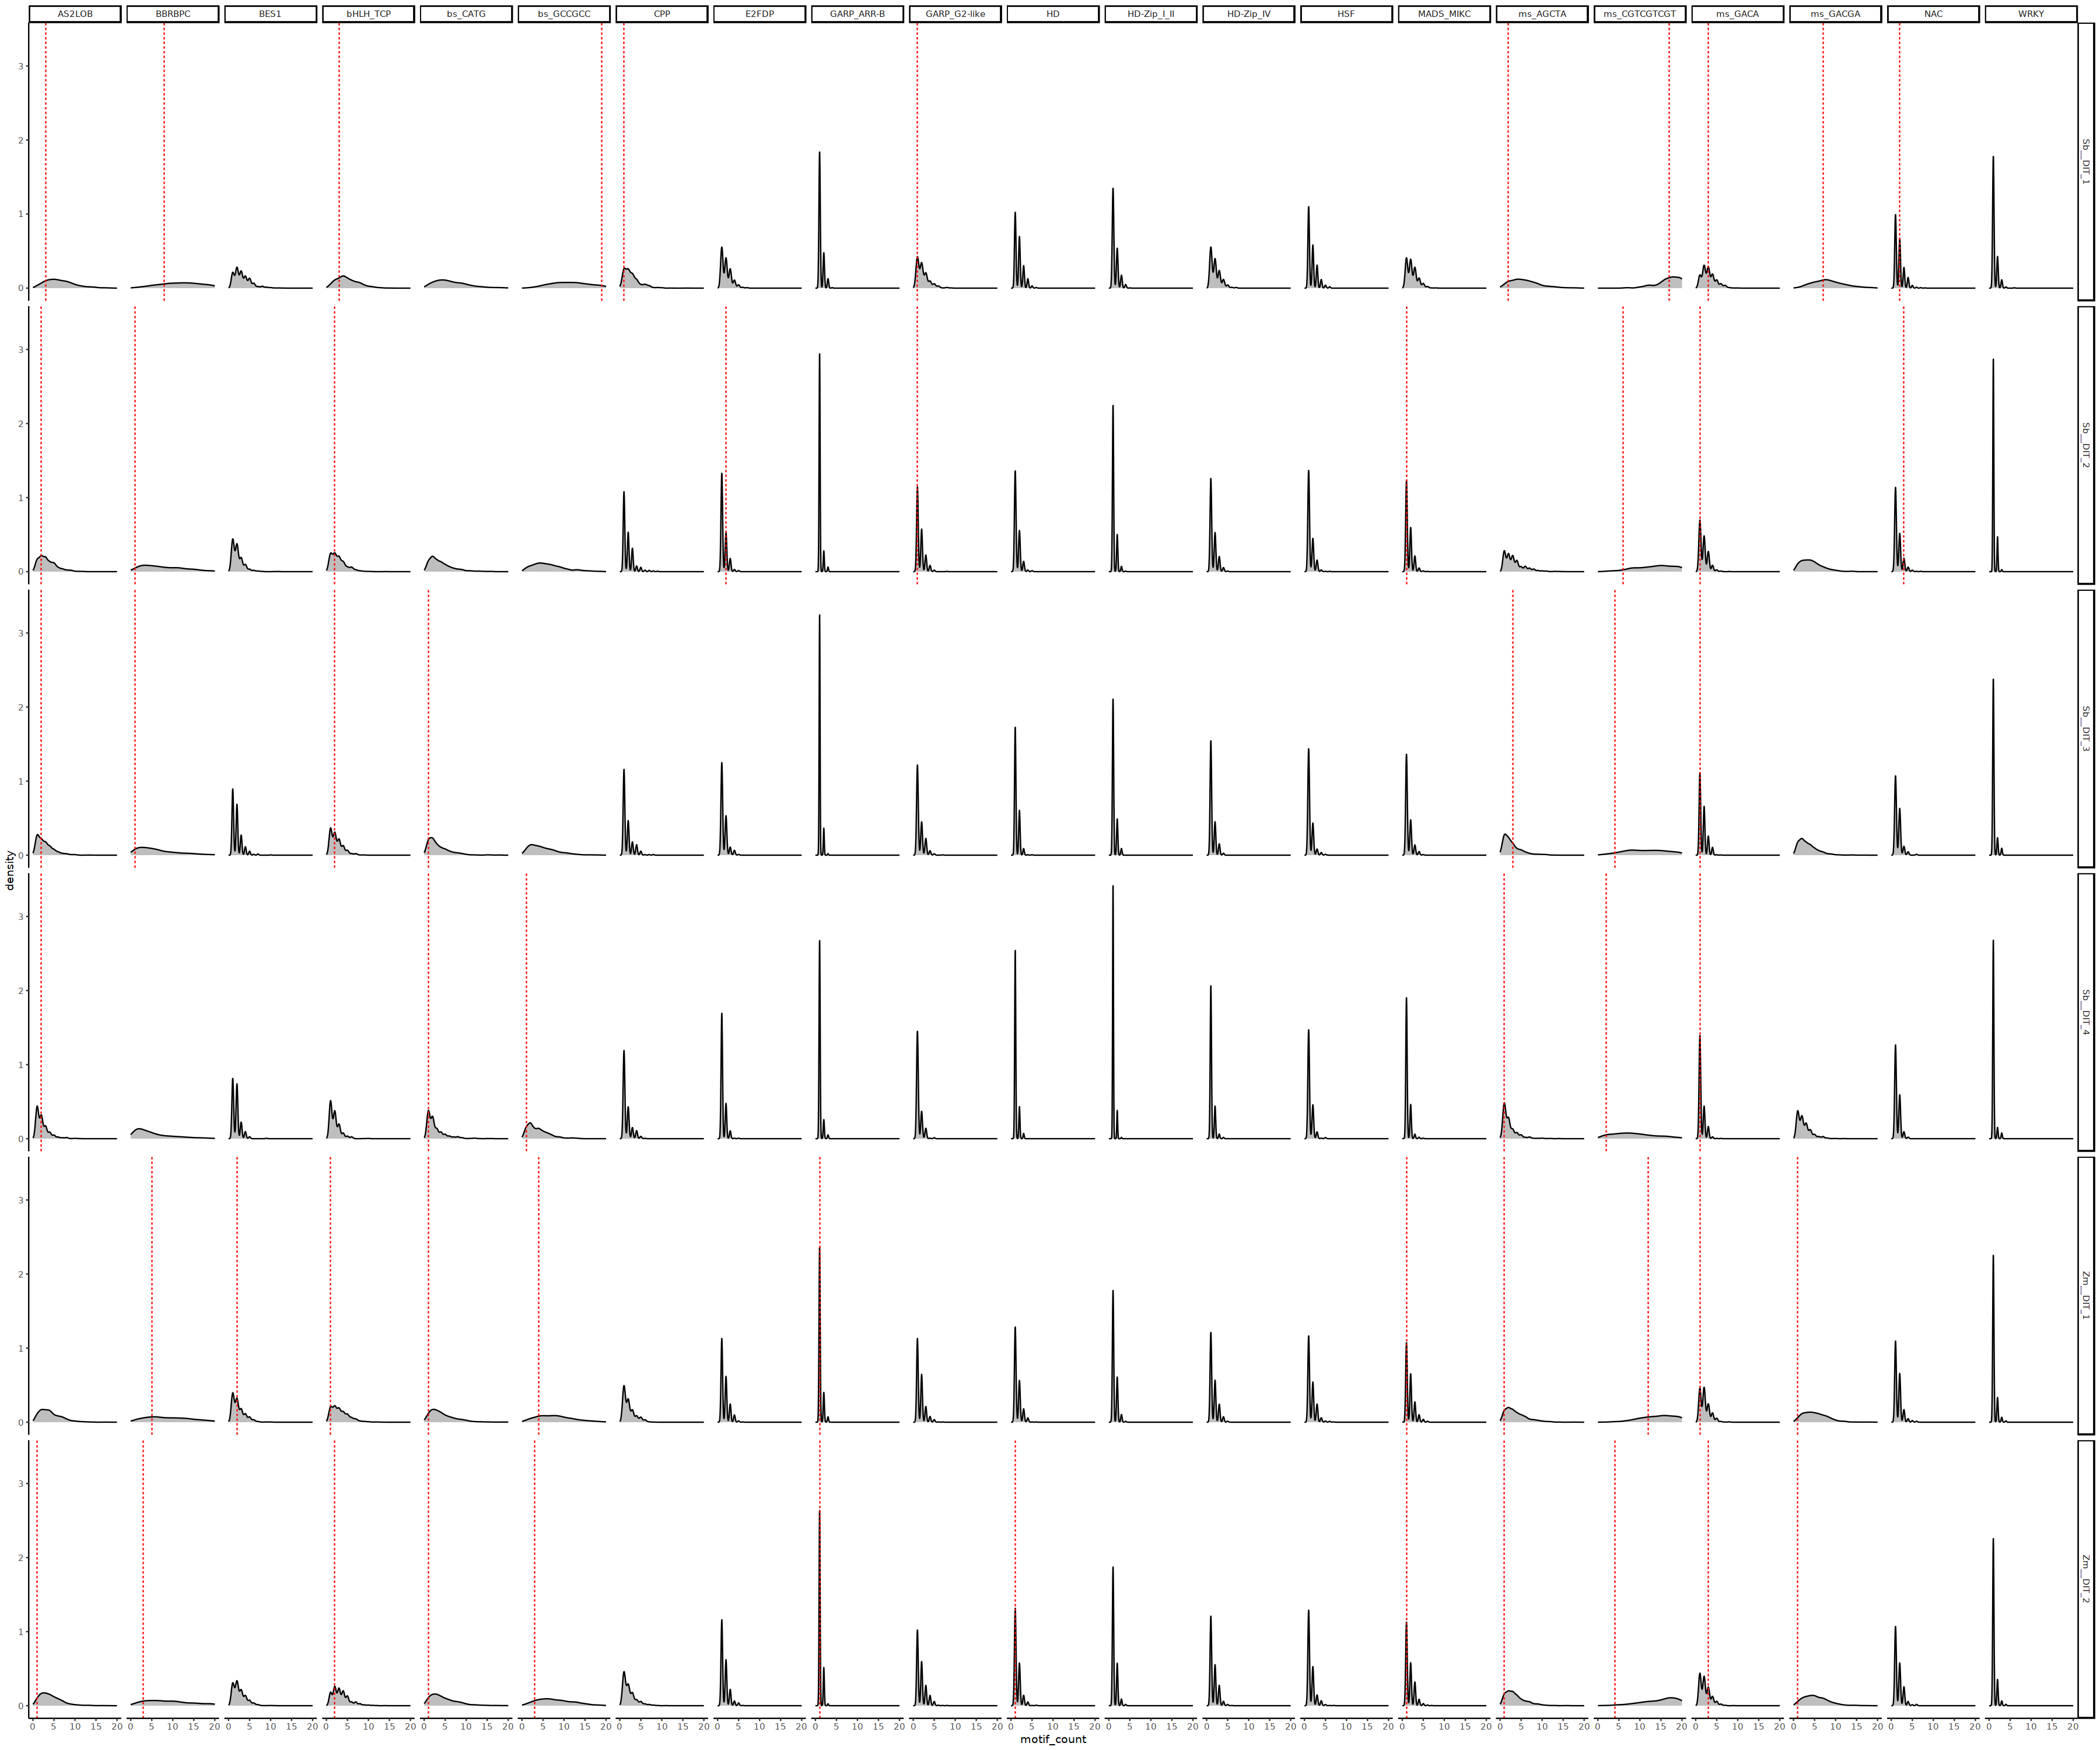

In [27]:
options(repr.plot.width=30, repr.plot.height=25)

ggplot(null_values, aes(x = motif_count)) + 
      geom_density(fill="gray")+
  geom_vline(data = for_plotting_density ,
                 aes(xintercept=total_motif_occurence), color="red",
                     linetype="dashed") +
    facet_grid(locus ~ motif_id) + 
  theme_classic() + xlim(0, 20)

## Running Fischer Exact Test -- Generating Contingency Tables

In [28]:
set.seed(1234)

sample_and_count_motifs <- function(acr_count, species, df) {
  acr_names <- df %>% 
    filter(species == species) %>%  # Filter by species
    sample_n(acr_count) 
    
  final <- df %>% 
    dplyr::filter(species == species & acr %in% acr_names$acr) %>% 
    dplyr::group_by(motif_id) %>% 
    dplyr::summarise(motif_count = n())
    
  return(final)
}

# Function to repeat sampling 5,000 times for a given acr_count and species
repeat_sampling_for_loci <- function(acr_count, species) {
  map_df(1, ~sample_and_count_motifs(acr_count, species, fimo_null_values))
}

# Apply repeat_sampling_for_loci to each row in dit_number_species
final_results <- dit_number_species %>%
  group_by(locus, species) %>%
  mutate(samples = map2(acr_count, species, ~repeat_sampling_for_loci(.x, .y)))


In [29]:
null_values_for_fischer <- final_results %>% 
    unnest(samples) %>% 
    dplyr::mutate(sample_type = "null") %>% 
    dplyr::select(-acr_count, -sample_type) %>% 
    dplyr::rename(null_motif_count = motif_count)

In [30]:
combined_motif_count_null <- left_join(w_cell_type, null_values_for_fischer, by = c("species", "locus", "motif_id")) %>% 
    mutate(null_motif_count = case_when(is.na(null_motif_count) == TRUE ~ 0,
                                  TRUE ~ null_motif_count))

In [31]:
library(broom)
results <- combined_motif_count_null %>%
  group_by(locus, motif_id) %>%
  summarize(
    observed = sum(total_motif_occurence),
    expected = sum(null_motif_count),
    .groups = 'keep'  # Keep the grouping
  ) %>%
  rowwise() %>%
  do({
    # Create the 2x2 contingency table
    tbl <- matrix(c(.$observed, .$expected, 
                    sum(.$observed, .$expected) - .$observed, 
                    sum(.$observed, .$expected) - .$expected), 
                  ncol = 2)
    # Perform Fisher's Exact Test and tidy the result
    test_result <- tidy(fisher.test(tbl))
    data.frame(locus = .$locus, motif_id = .$motif_id, test_result)
  })

# View results
print(results)

# A tibble: 43 × 8
# Rowwise: 
   locus     motif_id     estimate p.value conf.low conf.high method alternative
   <chr>     <chr>           <dbl>   <dbl>    <dbl>     <dbl> <chr>  <chr>      
 1 Sb__DIT_1 AS2LOB          0.586 1   e+0  0.0428      7.05  Fishe… two.sided  
 2 Sb__DIT_1 BBRBPC          0.126 3.00e-4  0.0330      0.428 Fishe… two.sided  
 3 Sb__DIT_1 CPP             0.156 4.86e-1  0.00161     4.72  Fishe… two.sided  
 4 Sb__DIT_1 GARP_G2-like  Inf     1   e+0  0.0256    Inf     Fishe… two.sided  
 5 Sb__DIT_1 NAC             3.11  1   e+0  0.0674    351.    Fishe… two.sided  
 6 Sb__DIT_1 bHLH_TCP        0.385 6.19e-1  0.0307      3.92  Fishe… two.sided  
 7 Sb__DIT_1 bs_GCCGCC      20.4   1.98e-5  4.09      138.    Fishe… two.sided  
 8 Sb__DIT_1 ms_AGCTA        0.483 1   e+0  0.0193      9.43  Fishe… two.sided  
 9 Sb__DIT_1 ms_CGTCGTCGT    0.506 1.85e-1  0.190       1.32  Fishe… two.sided  
10 Sb__DIT_1 ms_GACA       Inf     1   e-1  0.648     Inf     Fishe… two.sided

In [32]:
results %>% 
    dplyr::filter(p.value < .05)

locus,motif_id,estimate,p.value,conf.low,conf.high,method,alternative
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Sb__DIT_1,BBRBPC,0.12602060,2.995891e-04,0.0330402125,0.4279101,Fisher's Exact Test for Count Data,two.sided
Sb__DIT_1,bs_GCCGCC,20.43977716,1.982454e-05,4.0924619305,138.3094860,Fisher's Exact Test for Count Data,two.sided
Sb__DIT_2,ms_CGTCGTCGT,0.02978655,3.365822e-11,0.0067754068,0.1070108,Fisher's Exact Test for Count Data,two.sided
Zm__DIT_1,ms_CGTCGTCGT,0.25526316,9.048906e-03,0.0834000635,0.7376036,Fisher's Exact Test for Count Data,two.sided
Zm__DIT_2,AS2LOB,0.01586979,3.458873e-04,0.0002213550,0.2434798,Fisher's Exact Test for Count Data,two.sided
Zm__DIT_2,BBRBPC,0.04571853,1.519735e-04,0.0047980190,0.2874219,Fisher's Exact Test for Count Data,two.sided
Zm__DIT_2,ms_CGTCGTCGT,0.02272658,1.438342e-09,0.0035455456,0.1057279,Fisher's Exact Test for Count Data,two.sided
Zm__DIT_2,ms_GACGA,0.03163896,1.010101e-02,0.0004091944,0.5538700,Fisher's Exact Test for Count Data,two.sided


In [36]:

filtered_df <- combined_motif_count_null %>% filter(locus %in% c("Sb__DIT_1", "Sb__DIT_2"))

# Comparing motifs between Sb__DIT_1 and Sb__DIT_2
results <- filtered_df %>%
  group_by(motif_id) %>%
  summarize(
    Sb_DIT_1_observed = sum(total_motif_occurence[locus == "Sb__DIT_1"]),
    Sb_DIT_1_expected = sum(null_motif_count[locus == "Sb__DIT_1"]),
    Sb_DIT_2_observed = sum(total_motif_occurence[locus == "Sb__DIT_2"]),
    Sb_DIT_2_expected = sum(null_motif_count[locus == "Sb__DIT_2"]),
    .groups = 'drop'
  ) %>%
  rowwise() %>%
  do({
    # Create the 2x2 contingency table
    tbl <- matrix(c(.$Sb_DIT_1_observed, .$Sb_DIT_2_observed, 
                    .$Sb_DIT_1_expected, .$Sb_DIT_2_expected), 
                  ncol = 2)
    # Perform Fisher's Exact Test and tidy the result
    test_result <- tidy(fisher.test(tbl))
    data.frame(motif_id = .$motif_id, test_result)
  })

# View results
results






motif_id,estimate,p.value,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
AS2LOB,1.4538515,1.000000000,0.098648442,27.08736,Fisher's Exact Test for Count Data,two.sided
BBRBPC,1.0422001,1.000000000,0.070868854,61.52015,Fisher's Exact Test for Count Data,two.sided
CPP,0.0000000,1.000000000,0.000000000,Inf,Fisher's Exact Test for Count Data,two.sided
E2FDP,0.0000000,1.000000000,0.000000000,Inf,Fisher's Exact Test for Count Data,two.sided
GARP_G2-like,0.0000000,1.000000000,0.000000000,Inf,Fisher's Exact Test for Count Data,two.sided
MADS_MIKC,0.0000000,1.000000000,0.000000000,Inf,Fisher's Exact Test for Count Data,two.sided
NAC,0.7071212,1.000000000,0.006400778,78.18398,Fisher's Exact Test for Count Data,two.sided
bHLH_TCP,0.9073500,1.000000000,0.056996164,17.16228,Fisher's Exact Test for Count Data,two.sided
bs_GCCGCC,0.0000000,1.000000000,0.000000000,Inf,Fisher's Exact Test for Count Data,two.sided


In [ ]:
combined_null_real

In [ ]:
fisher_test_from_row <- function(count_motif_occurence, non_motif_occurence, null_count_motif_occurence, null_count_non_motif_occurence) {
  matrix_data <- c(count_motif_occurence, null_count_motif_occurence, non_motif_occurence, null_count_non_motif_occurence)
  matrix_for_test <- matrix(matrix_data, nrow = 2)
  fisher_result <- fisher.test(matrix_for_test)
  return(fisher_result$p.value)
}

# Apply the function to each row
combined_null_real.pvals <- combined_null_real %>%
  rowwise() %>%
  mutate(p_value = purrr::pmap_dbl(list(count_motif_occurence, non_motif_occurence, null_count_motif_occurence, null_count_non_motif_occurence), fisher_test_from_row))

print(combined_null_real.pvals)